# **임대주택 단지 내 적정 주차수요 예측 대회**

2021년 7월 10일

In [1]:
PATH = r'C:\Users\Wyatt\wyatt37\data\parking'

In [2]:
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
from tabulate import tabulate

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LassoLars, HuberRegressor

In [4]:
from pycaret.regression import *

In [141]:
age_gender = pd.read_csv(PATH + '\\new_age_gender_info.csv')
train = pd.read_csv(PATH + '\\new_train.csv')
test = pd.read_csv(PATH + '\\new_test.csv')
sub = pd.read_csv(PATH + '\\new_sample_submission.csv')

# PREPROCESSING

In [142]:
# 컬럼명이 너무 긴 지하철과 버스만 바꿔주겠습니다.
train.rename({'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철',
             '도보 10분거리 내 버스정류장 수': '버스'}, axis=1, inplace=True)
test.rename({'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철',
             '도보 10분거리 내 버스정류장 수': '버스'}, axis=1, inplace=True)

## FILLNA

### Subway

In [143]:
# train set에 지하철 정보가 없는 경남, 충남은 0으로 보간
train.loc[(train['지역'].isin(['경상남도', '충청남도'])) & (train['지하철'].isnull()), '지하철'] = 0

In [144]:
# LH청약센터에서 찾은 주소로 확인한 대전의 8개 단지는 지하철이 없음
# 0으로 채워줍시다.

(train.loc[(train['지역'] == '대전광역시') & (train['지하철'].isnull()) , '지하철']) = 0

In [145]:
# test set에 지하철 정보가 없는 충남은 0으로 보간
test.loc[(test['지역'].isin(['충청남도'])) & (test['지하철'].isnull()), '지하철'] = 0

In [146]:
# LH청약센터에서 찾은 주소로 확인한 대전의 2개 단지는 지하철이 없음
# 0으로 채워줍시다.

(test.loc[(test['지역'] == '대전광역시') & (test['지하철'].isnull()), '지하철']) = 0

### Bus

In [147]:
# 버스정류장 결측치는 train set에 1개 단지에 존재
# 해당 단지는 양산신도시LH아파트 5단지
# 동일 단지인 C2431에서 2로 되어 있음.

train.loc[train['버스'].isnull(), '버스'] = 2

### Rent

In [148]:
# test set 에 임대보증금과 임대료가 결측치인 1개 단지 존재
# 해당 단지는 대전둔산1단지주공아파트
# 공고문에 의거, 임대보증금과 임대료 아래와 같이 보간

test.loc[(test['임대건물구분'] != '상가') & (test['임대보증금'].isnull()), '임대보증금'] = [5787000, 5787000, 11574000]
test.loc[(test['임대건물구분'] != '상가') & (test['임대료'].isnull()), '임대료'] = [79980, 79980, 159960]

### Qualification

In [149]:
# C2411 아파트의 자격유형은 전부 A로 되어 있음.
# 동일하게 A로 보간

test.loc[(test['단지코드'] == 'C2411') & (test['자격유형'].isnull()), '자격유형'] = 'A'

In [150]:
# C2253 아파트의 자격유형은 전부 C로 되어 있음.
# 동일하게 C로 보간

test.loc[(test['단지코드'] == 'C2253') & (test['자격유형'].isnull()), '자격유형'] = 'C'

## REPLACING

https://www.dacon.io/competitions/official/235745/talkboard/403708?page=1&dtype=recent

※ 동일한 단지에 코드가 2개로 부여된 단지 코드 (3쌍) : ['C2085', 'C1397'], ['C2431', 'C1649'], ['C1036', 'C2675'] 
 - C2675 단지는 테스트셋, 나머지는 트레인셋 입니다.

In [151]:
# ['C2085', 'C1397'] 을 C1397로 합병
train.loc[train['단지코드'] == 'C2085', '단지코드'] = 'C1397'
train.loc[train['단지코드'] == 'C1397', '총세대수'] = (
    train.loc[train['단지코드'] == 'C1397'].groupby(['단지코드'])['전용면적별세대수'].sum()[0]
)
train.loc[train['단지코드'] == 'C1397', '공가수'] = 9

In [152]:
# ['C2431', 'C1649'] 을 C1649로 합병
train.loc[train['단지코드'] == 'C2431', '단지코드'] = 'C1649'
train.loc[train['단지코드'] == 'C1649', '총세대수'] = (
    train.loc[train['단지코드'] == 'C1649'].groupby(['단지코드'])['전용면적별세대수'].sum()[0]
)
train.loc[train['단지코드'] == 'C1649', '공가수'] = 31
train.loc[train['단지코드'] == 'C1649', '등록차량수'] = 1214

In [153]:
# ['C1036', 'C2675'] 은 train과 test로 나누어져 있으니 drop
train.drop(train.loc[train['단지코드'] == 'C1036'].index, axis=0, inplace=True)
test.drop(test.loc[test['단지코드'] == 'C2675'].index, axis=0, inplace=True)

※ 차이가 94~452세대인 10개 단지(크기순) : ['C1490', 'C2497', 'C2620', 'C1344', 'C1024', 'C2470', 'C1206', 'C1740', 'C2405', 'C1804’]

In [154]:
# 경북혁신도시천년나무3단지
test.loc[test['단지코드'] == 'C2497', '전용면적별세대수'] = [114, 60, 275, 39]


# 충무공동혁신도시LH아파트5단지
train.loc[train['단지코드'] == 'C2405', '전용면적별세대수'] = [100, 100, 400]
# 경북혁신LH천년나무2단지
train.loc[train['단지코드'] == 'C1740', '전용면적별세대수'] = [305, 126, 184, 168]
# LH강남아이파크
train.loc[train['단지코드'] == 'C1024', '전용면적별세대수'] = [195, 60, 15, 154, 99, 48, 42, 53, 29, 23]
# 서울서초A4BL
train.loc[train['단지코드'] == 'C1344', '전용면적별세대수'] = [106, 96, 41, 39, 42, 100]
# 진천군 연미로 131 천년나무7단지
train.loc[train['단지코드'] == 'C1490', '전용면적별세대수'] = [105, 84, 472, 88]
# 나주빛가람LH3단지
train.loc[train['단지코드'] == 'C2620', '전용면적별세대수'] = [60, 227, 316, 160, 266]
# 남양주별내A1-3블록
train.loc[train['단지코드'] == 'C1804', '전용면적별세대수'] = [76, 82, 279, 28]
train = train.append({'단지코드': 'C1804',
              '총세대수': 478,
              '임대건물구분': '아파트',
              '지역': '경기도',
              '공급유형': '공공임대(10년)',
              '전용면적': 75.78,
              '전용면적별세대수': 13,
              '공가수': 3.0,
              '자격유형': 'A',
              '임대보증금': 78957000,
              '임대료': 530130,
              '지하철': 0.0,
              '버스': 3.0,
              '단지내주차면수': 629.0,
              '등록차량수': 951.0}, ignore_index=True)
# 대전대신2구역2단지
train = train.append({'단지코드': 'C2470',
                      '총세대수': 636,
                      '임대건물구분': '아파트',
                      '지역': '대전광역시',
                      '공급유형': '공공분양',
                      '전용면적': 74.99,
                      '전용면적별세대수': 72,
                      '공가수': 1.0,
                      '자격유형': 'A',
                      '임대보증금': 225013300,
                      '지하철': 1.0,
                      '버스': 2.0,
                      '단지내주차면수': 772.0,
                      '등록차량수': 887.0}, ignore_index=True)
train = train.append({'단지코드': 'C2470',
                      '총세대수': 636,
                      '임대건물구분': '아파트',
                      '지역': '대전광역시',
                      '공급유형': '공공분양',
                      '전용면적': 74.95,
                      '전용면적별세대수': 66,
                      '공가수': 1.0,
                      '자격유형': 'A',
                      '임대보증금': 226278000,
                      '지하철': 1.0,
                      '버스': 2.0,
                      '단지내주차면수': 772.0,
                      '등록차량수': 887.0}, ignore_index=True)
train = train.append({'단지코드': 'C2470',
                      '총세대수': 636,
                      '임대건물구분': '아파트',
                      '지역': '대전광역시',
                      '공급유형': '공공분양',
                      '전용면적': 74.99,
                      '전용면적별세대수': 92,
                      '공가수': 1.0,
                      '자격유형': 'A',
                      '임대보증금': 230417000,
                      '지하철': 1.0,
                      '버스': 2.0,
                      '단지내주차면수': 772.0,
                      '등록차량수': 887.0}, ignore_index=True)
# 속초청초아파트
#train.loc[train['단지코드'] == 'C1206', '총세대수'] = 478
train = train.append({'단지코드': 'C1206',
                      '총세대수': 755,
                      '임대건물구분': '아파트',
                      '지역': '강원도',
                      '공급유형': '공공분양',
                      '전용면적': 41.85,
                      '전용면적별세대수': 177,
                      '공가수': 1.0,
                      '자격유형': 'A',
                      '임대보증금': 50000000,
                      '지하철': 0.0,
                      '버스': 4.0,
                      '단지내주차면수': 88.0,
                      '등록차량수': 90.0}, ignore_index=True)
train = train.append({'단지코드': 'C1206',
                      '총세대수': 755,
                      '임대건물구분': '아파트',
                      '지역': '강원도',
                      '공급유형': '공공분양',
                      '전용면적': 51.66,
                      '전용면적별세대수': 90,
                      '공가수': 1.0,
                      '자격유형': 'A',
                      '임대보증금': 65000000,
                      '지하철': 0.0,
                      '버스': 4.0,
                      '단지내주차면수': 88.0,
                      '등록차량수': 90.0}, ignore_index=True)

In [155]:
# train의 C1024는 다른 단지와 다르게 총세대수보다 전용면적별세대수합이 더 큽니다.
train.loc[train['단지코드'] == 'C1024', '총세대수'] = (
    train.loc[train['단지코드'] == 'C1024'].groupby(['단지코드'])['전용면적별세대수'].sum()[0]
)

※ 실수가 발생한 단지 코드 (9개 단지) : ['C2335', 'C1327', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
 - C2335, C1327 단지는 테스트셋, 나머지는 트레인셋 입니다.

In [156]:
# 노이즈로 판결났으므로 부득이하게 레코드 드랍
train.drop(train.loc[train['단지코드'].isin(['C2335', 'C1327', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988'])].index, axis=0, inplace=True)
test.drop(test.loc[test['단지코드'].isin(['C2335', 'C1327', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988'])].index, axis=0, inplace=True)

### Qualification

'D' 는 상가에서 보여지는 자격유형입니다. 그러나 train, test 셋에 각각 존재합니다.

In [157]:
# train의 C1350의 D는 최빈값 A로 넣겠습니다.
train.loc[(train['자격유형'] == 'D') & (train['임대건물구분'] == '아파트'), '자격유형'] = (
    train.loc[(train['단지코드'] == 'C1350') & (~train['임대료'].isnull()), '자격유형'].mode()[0]
)

In [158]:
# test의 C1006의 D값은 최빈값인 C로 대체하겠습니다.
test.loc[(test['단지코드'] == 'C1006') & (test['임대건물구분'] == '아파트'), '자격유형'] = (
    test.loc[(test['단지코드'] == 'C1006') & (test['임대건물구분'] == '아파트'), '자격유형'].mode()[0]
)

### Deposit / Rent Preprocessing

임대료가 없는 단지를 비교하기 위해서 임대료를 만들어주겠습니다.

In [159]:
# '-' 값을 0으로 만들어줍니다.
train.loc[train['임대보증금'] == '-', '임대보증금'] = 0
test.loc[test['임대보증금'] == '-', '임대보증금'] = 0

train.loc[train['임대료'] == '-', '임대료'] = 0
test.loc[test['임대료'] == '-', '임대료'] = 0

In [160]:
# nan 값 때문에 object로 되어 있습니다. 일단 0으로 채워 줍니다.
train['임대보증금'] = train['임대보증금'].fillna(0)
test['임대보증금'] = test['임대보증금'].fillna(0)

train['임대료'] = train['임대료'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)

In [161]:
# 계산을 위해서 int로 바꿔줍니다.
train['임대보증금'] = train['임대보증금'].astype(int)
test['임대보증금'] = test['임대보증금'].astype(int)

train['임대료'] = train['임대료'].astype(int)
test['임대료'] = test['임대료'].astype(int)

In [162]:
# 면적당으로 보증금과 임대료를 산출해서 역으로 채워넣겠습니다.
train['면적당보증금'] = train['임대보증금'] / train['전용면적']
train['면적당임대료'] = train['임대료'] / train['전용면적']

test['면적당보증금'] = test['임대보증금'] / test['전용면적']
test['면적당임대료'] = test['임대료'] / test['전용면적']

In [163]:
# 0 값을 다시 NULL 값으로 바꿉니다.
train.loc[(train['면적당보증금'] == 0), ['임대보증금', '면적당보증금']] = np.nan
train.loc[(train['면적당임대료'] == 0), ['임대료', '면적당임대료']] = np.nan

test.loc[(test['면적당보증금'] == 0), ['임대보증금', '면적당보증금']] = np.nan
test.loc[(test['면적당임대료'] == 0), ['임대료', '면적당임대료']] = np.nan

train에서 공공분양, 장기전세가 아니면서 보증금과 임대료가 비어있는 곳은 C1350, C1786, C2186, C1326 입니다.

In [164]:
# C1350은 공공분양이기 때문에 임대료가 없고 보증금이 매우 큽니다.
# 이 경우는 비슷한 공급유형의 면적당보증금을 가져오겠습니다.
# 임대료는 추후 작업하겠습니다.

# 같은 유형의 공공분양 단지의 면적당 보증금의 평균으로 채워줍니다.
train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '공공분양') & (~train['임대보증금'].isnull()), '면적당보증금'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '면적당보증금']
)

In [165]:
# C1786 은 행복주택, K 유형의 아파트입니다.
# 동일한 공급유형, 자격유형의 값을 가져오겠습니다.
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'K'), '면적당보증금'].mean()
)
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당임대료'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'K'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '전용면적']
    * train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당보증금']
)
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '임대료'] = (
    train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '전용면적']
    * train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당임대료']
)

In [166]:
# C2186 단지는 같은 단지에 동일한 공급유형, 동일한 자격유형의 값이 있습니다.
# 해당 값으로 넣어주겠습니다.
train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '면적당임대료'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['자격유형'] == 'H') & (~train['임대료'].isnull()), '면적당임대료'].mean()
)
train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['자격유형'] == 'H') & (~train['임대보증금'].isnull()), '면적당보증금'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '임대료'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '면적당임대료']
)
train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '면적당보증금']
)

In [167]:
# C1326 단지는 동일 지역에 H국민임대 단지가 없습니다. 전국적으로 4000~6500원 선이니 평균으로 넣어주겠습니다.
train.loc[train['단지코드'] == 'C1326', '면적당보증금'] = (
    train.loc[(train['공급유형'] == '국민임대') & (train['자격유형'] == 'H'), '면적당보증금'].mean()
)
train.loc[train['단지코드'] == 'C1326', '면적당임대료'] = (
    train.loc[(train['공급유형'] == '국민임대') & (train['자격유형'] == 'H'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[train['단지코드'] == 'C1326', '임대보증금'] = (
    train.loc[train['단지코드'] == 'C1326', '면적당보증금']
    * train.loc[train['단지코드'] == 'C1326', '전용면적']
)
train.loc[train['단지코드'] == 'C1326', '임대료'] = (
    train.loc[train['단지코드'] == 'C1326', '면적당임대료']
    * train.loc[train['단지코드'] == 'C1326', '전용면적']
)

test의 보증금과 임대료가 비어 있는 곳은 C1267, C2152 입니다.

In [168]:
# C1267 단지는 train의 동일공급유형, 동일자격유형, 거기에 경기도를 뺀 지역의 평균을 넣겠습니다.
test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'L') & (train['지역'] != '경기도'), '면적당보증금'].mean()
)
test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '면적당임대료'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'L') & (train['지역'] != '경기도'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '임대보증금'] = (
    test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '전용면적']
    * test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '면적당보증금']
)
test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '임대료'] = (
    test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '전용면적']
    * test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '면적당임대료']
)

In [169]:
# C2152 단지는 train의 동일 공급유형, 자격유형의 전국 평균 값으로 넣겠습니다.
test.loc[test['단지코드'] == 'C2152', '면적당보증금'] = (
    train.loc[(train['공급유형'] == '영구임대') & (train['자격유형'] == 'C'), '면적당보증금'].mean()
)
test.loc[test['단지코드'] == 'C2152', '면적당임대료'] = (
    train.loc[(train['공급유형'] == '영구임대') & (train['자격유형'] == 'C'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
test.loc[test['단지코드'] == 'C2152', '임대보증금'] = (
    test.loc[test['단지코드'] == 'C2152', '전용면적']
    * test.loc[test['단지코드'] == 'C2152', '면적당보증금']
)
test.loc[test['단지코드'] == 'C2152', '임대료'] = (
    test.loc[test['단지코드'] == 'C2152', '전용면적']
    * test.loc[test['단지코드'] == 'C2152', '면적당임대료']
)

장기전세와 공공분양 ['C1397', 'C1039', 'C1350', 'C2470', 'C1206']

In [170]:
train['임대료'] = train['임대료'].fillna(0)

In [176]:
train['환산보증금'] = train['임대료'] * 354 + train['임대보증금']
test['환산보증금'] = test['임대료'] * 354 + test['임대보증금']

In [182]:
train['면적당환산보증금'] = train['환산보증금'] / train['전용면적']
test['면적당환산보증금'] = test['환산보증금'] / test['전용면적']

# INVESTIGATION

In [183]:
train_apart = train[['단지코드', '임대건물구분', '공급유형', '전용면적',
                     '전용면적별세대수', '자격유형', '임대보증금', '임대료']].loc[train['임대건물구분'] == '아파트']

train_shop = train[['단지코드', '임대건물구분', '공급유형', '전용면적',
                    '전용면적별세대수', '자격유형']].loc[train['임대건물구분'] == '상가']

train_danji = train[['단지코드', '총세대수', '지역', '공가수', '지하철',
                     '버스', '단지내주차면수', '등록차량수']].drop_duplicates().reset_index(drop=True)

test_apart = test[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형',
                   '임대보증금', '임대료']].loc[test['임대건물구분'] == '아파트']

test_shop = test[['단지코드', '임대건물구분', '공급유형', '전용면적', '전용면적별세대수',
                  '자격유형']].loc[test['임대건물구분'] == '상가']

test_danji = test[['단지코드', '총세대수', '지역', '공가수', '지하철',
                   '버스', '단지내주차면수']].drop_duplicates().reset_index(drop=True)

### 산점도(등록차량수, 주차면수)

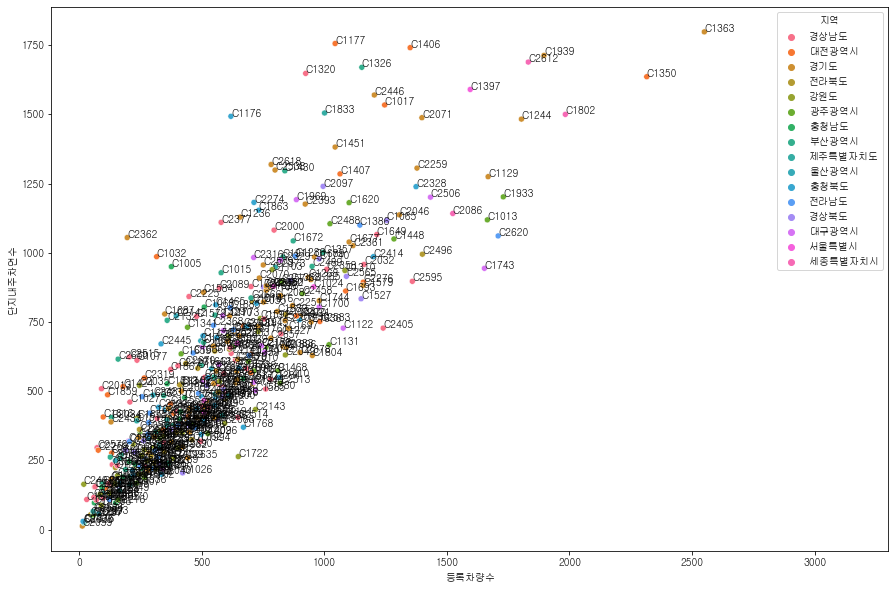

In [184]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_danji, x='등록차량수', y='단지내주차면수', hue='지역')
for i, code in enumerate(train_danji['단지코드']):
    plots.annotate(code, (train_danji['등록차량수'][i], train_danji['단지내주차면수'][i]))
plt.xlim(right=3300)
plt.show()

In [185]:
train_danji.loc[train_danji['단지코드'] == 'C2362']

단지코드  총세대수   지역   공가수  지하철   버스  단지내주차면수  등록차량수
388  C2362  1509  경기도  46.0  0.0  2.0   1055.0  196.0

### 산점도(총세대수, 주차면수)

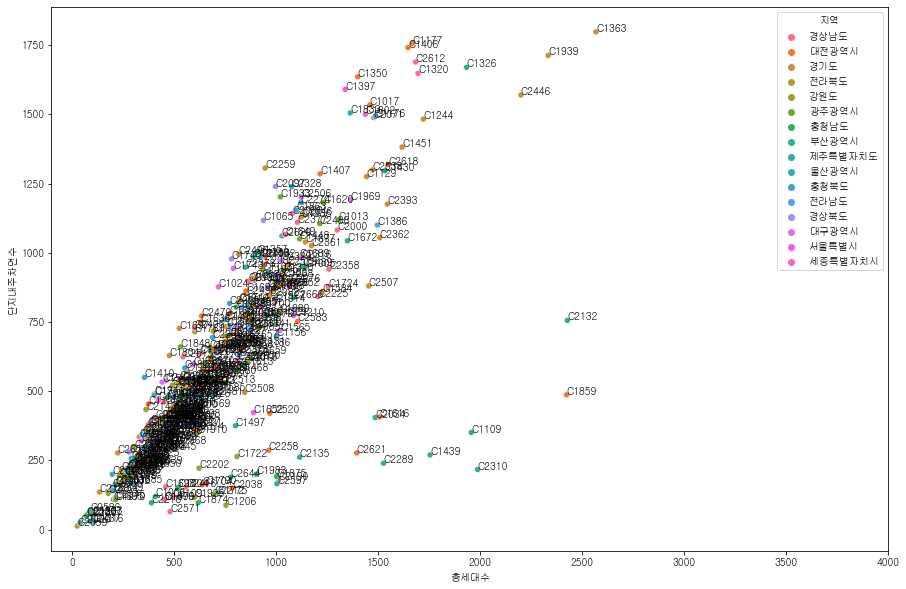

In [186]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_danji, x='총세대수', y='단지내주차면수', hue='지역')
for i, code in enumerate(train_danji['단지코드']):
    plots.annotate(code, (train_danji['총세대수'][i], train_danji['단지내주차면수'][i]))
plt.xlim(right=4000)
plt.show()

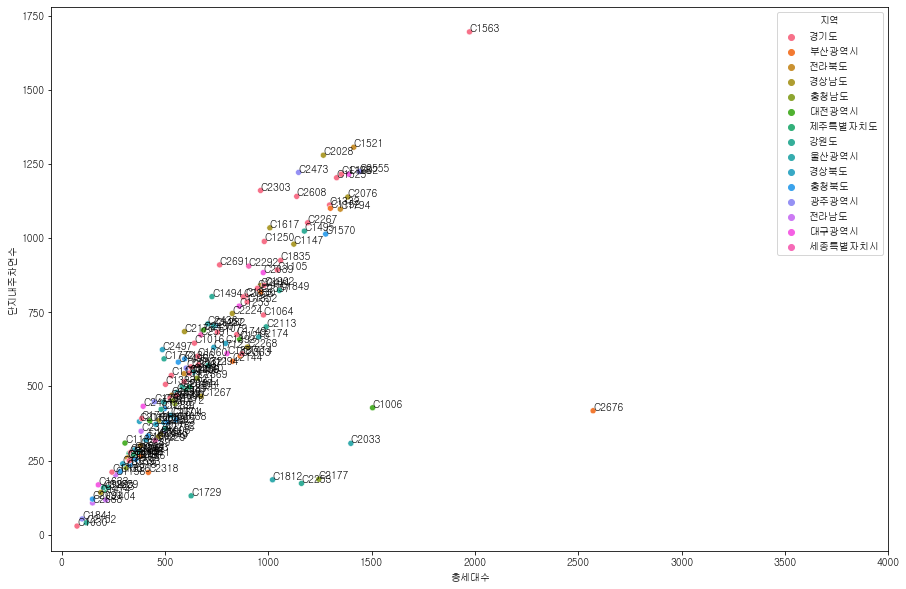

In [187]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=test_danji, x='총세대수', y='단지내주차면수', hue='지역')
for i, code in enumerate(test_danji['단지코드']):
    plots.annotate(code, (test_danji['총세대수'][i], test_danji['단지내주차면수'][i]))
plt.xlim(right=4000)
plt.show()

### 산점도(건축연면적, 주차면수)

In [188]:
train['건축연면적'] = train['전용면적'] * train['전용면적별세대수']
test['건축연면적'] = test['전용면적'] * test['전용면적별세대수']

In [189]:
temp = train.groupby(['단지코드']).sum().reset_index()
train_size = pd.merge(train_danji, temp[['단지코드', '건축연면적']], how='inner', on='단지코드')

In [190]:
temp = test.groupby(['단지코드']).sum().reset_index()
test_size = pd.merge(test_danji, temp[['단지코드', '건축연면적']], how='inner', on='단지코드')

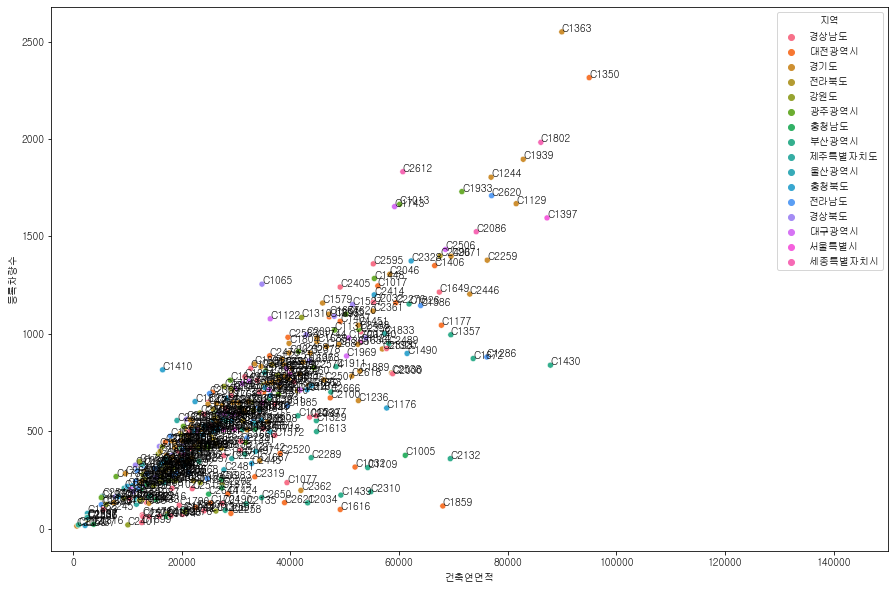

In [193]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_size, x='건축연면적', y='등록차량수', hue='지역')
for i, code in enumerate(train_size['단지코드']):
    plots.annotate(code, (train_size['건축연면적'][i], train_size['등록차량수'][i]))
plt.xlim(right=150000)
plt.show()

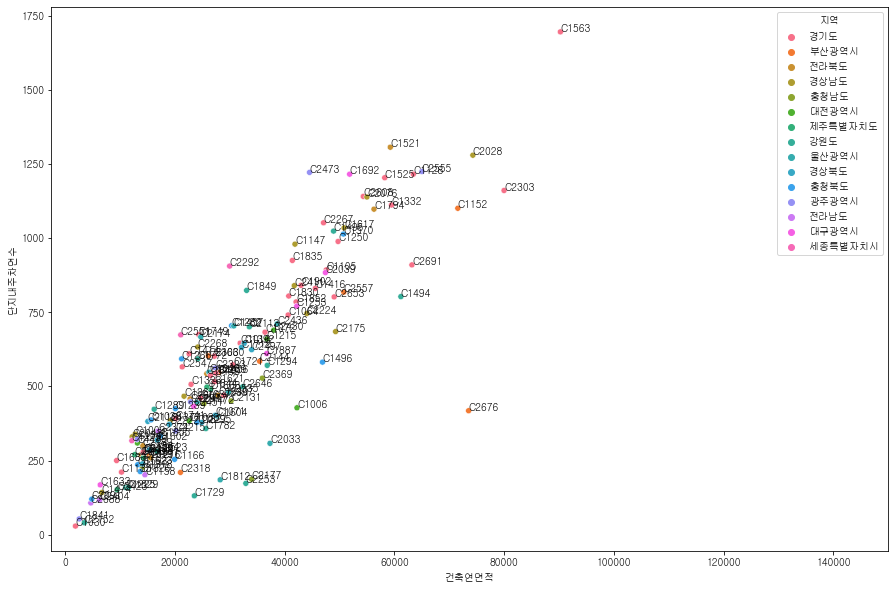

In [192]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=test_size, x='건축연면적', y='단지내주차면수', hue='지역')
for i, code in enumerate(test_size['단지코드']):
    plots.annotate(code, (test_size['건축연면적'][i], test_size['단지내주차면수'][i]))
plt.xlim(right=150000)
plt.show()

건축연면적으로 따져도 추세선을 벗어나는 단지가 몇 개 있습니다.

### 레그플롯-지역별(총세대수, 등록차량수)

지역별로 살펴봐야겠습니다. 지역별로 법정주차대수가 다르기 때문에 그래프가 다르게 나타날 수 있습니다.

In [195]:
train_danji.head()

단지코드  총세대수     지역   공가수  지하철   버스  단지내주차면수   등록차량수
0  C2515   545   경상남도  17.0  0.0  3.0    624.0   205.0
1  C1407  1216  대전광역시  13.0  1.0  1.0   1285.0  1064.0
2  C1945   755    경기도   6.0  1.0  3.0    734.0   730.0
3  C1470   696   전라북도  14.0  0.0  2.0    645.0   553.0
4  C1898   566   전라북도   9.0  0.0  6.0    517.0   415.0

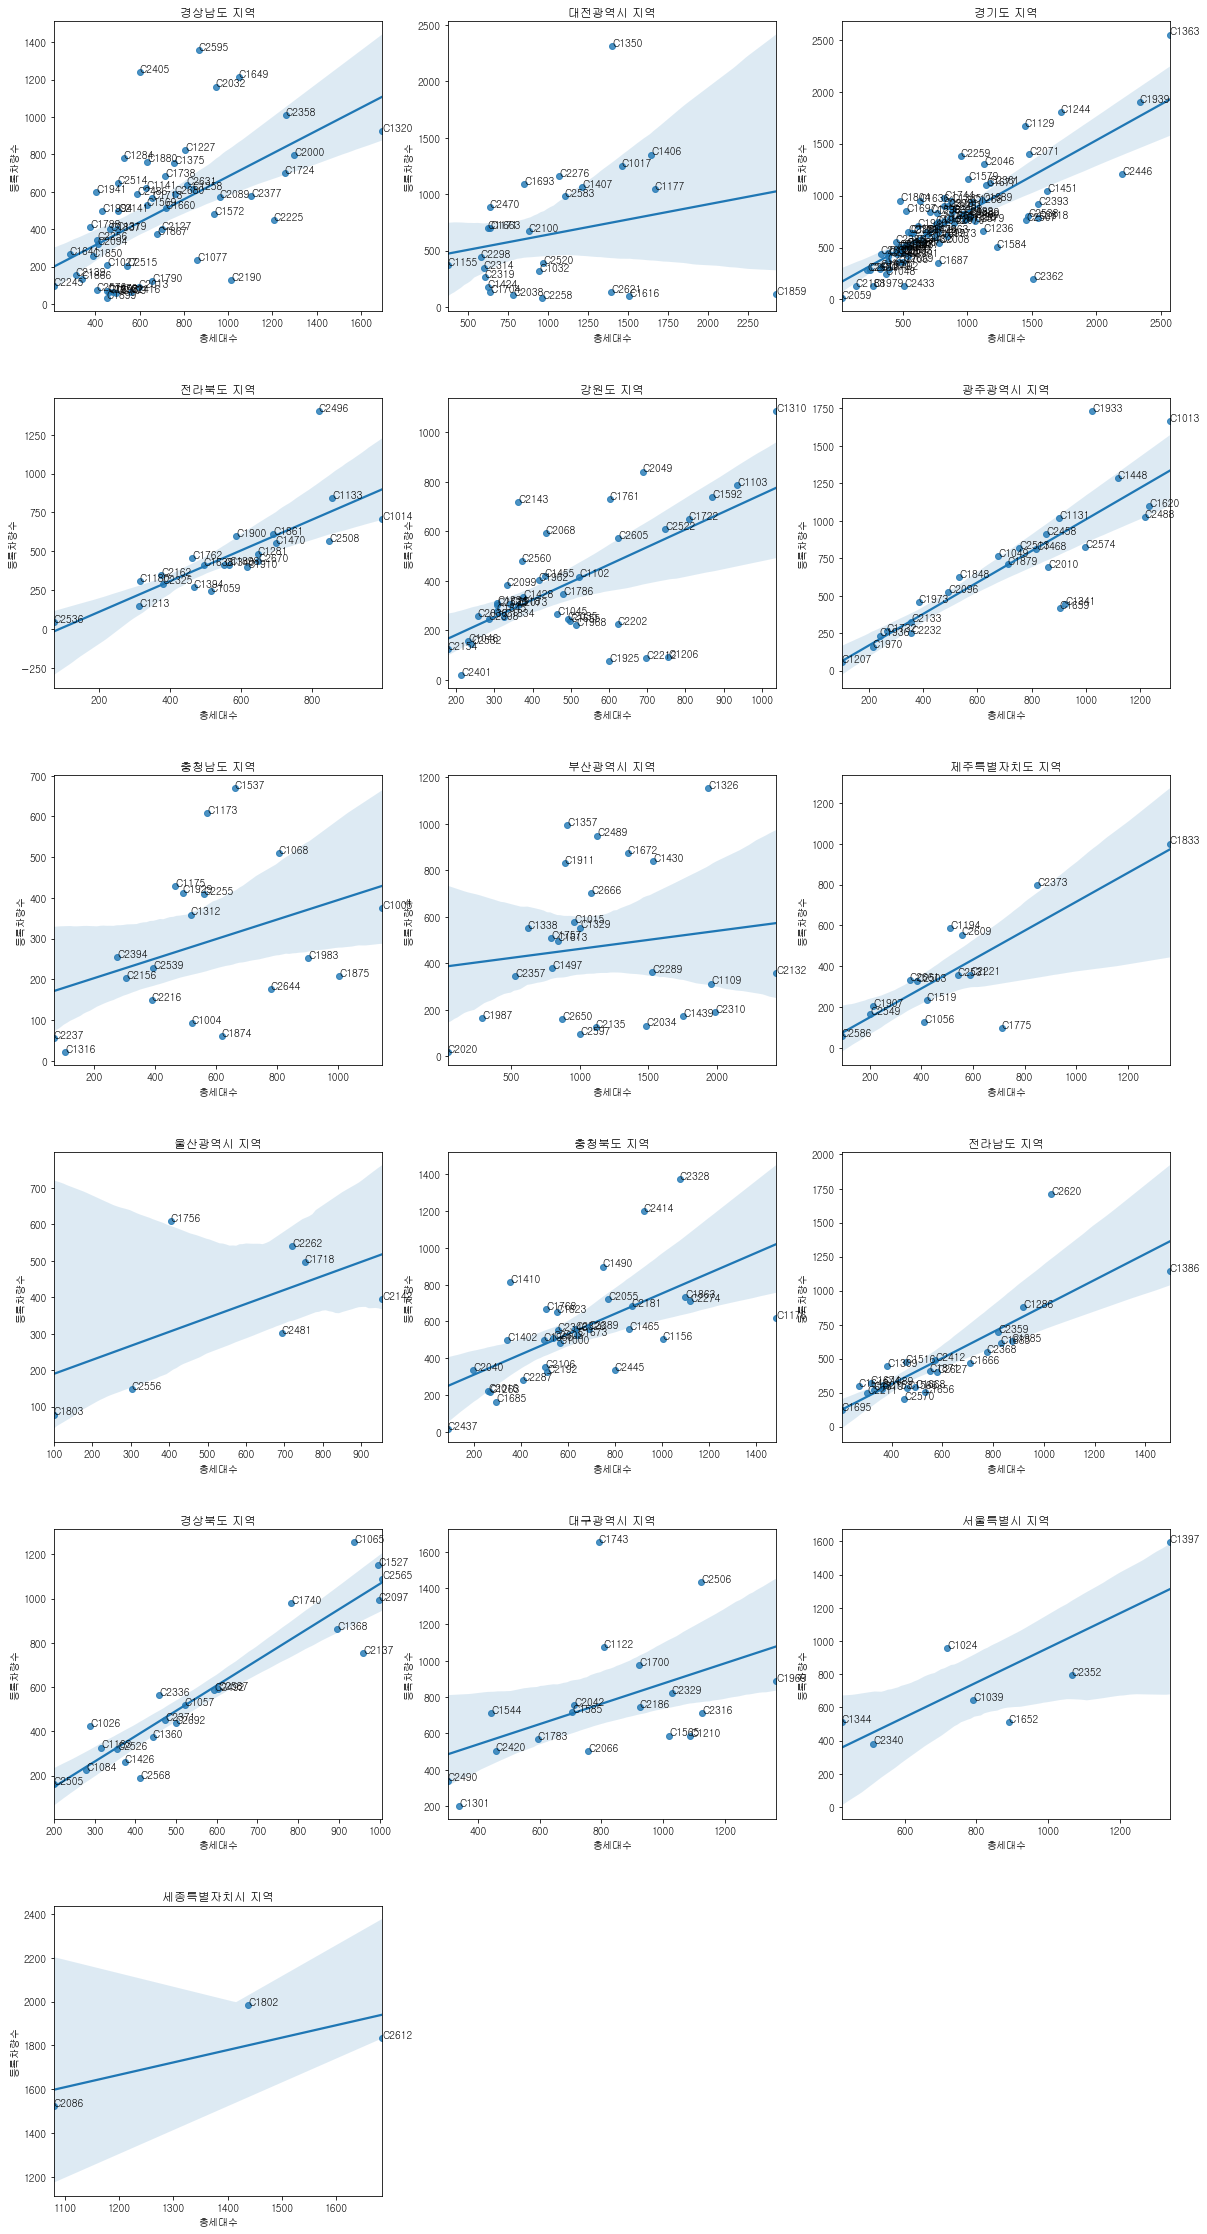

In [196]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_danji['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_danji.loc[train_danji['지역'] == n], x='총세대수', y='등록차량수')
    for i, code in enumerate(train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['총세대수'][i],
                              train_danji.loc[train_danji['지역'] == n].reset_index(drop=True)['등록차량수'][i]))
    plt.title('{} 지역'.format(n))

- 보통은 법정주차대수 때문에 총세대수와 주차면수는 곧은 선형관계를 띄게 되어 있습니다.
- 그런데 우측 하단에 그 관계를 벗어나는 군집이 나타납니다. 대전, 강원도, 충남, 부산이 특히 그렇습니다.
- 가설은 아주 오래된 아파트이거나, 자차를 소유하지 않은 주민들이 많이 사는 지역일 가능성입니다.

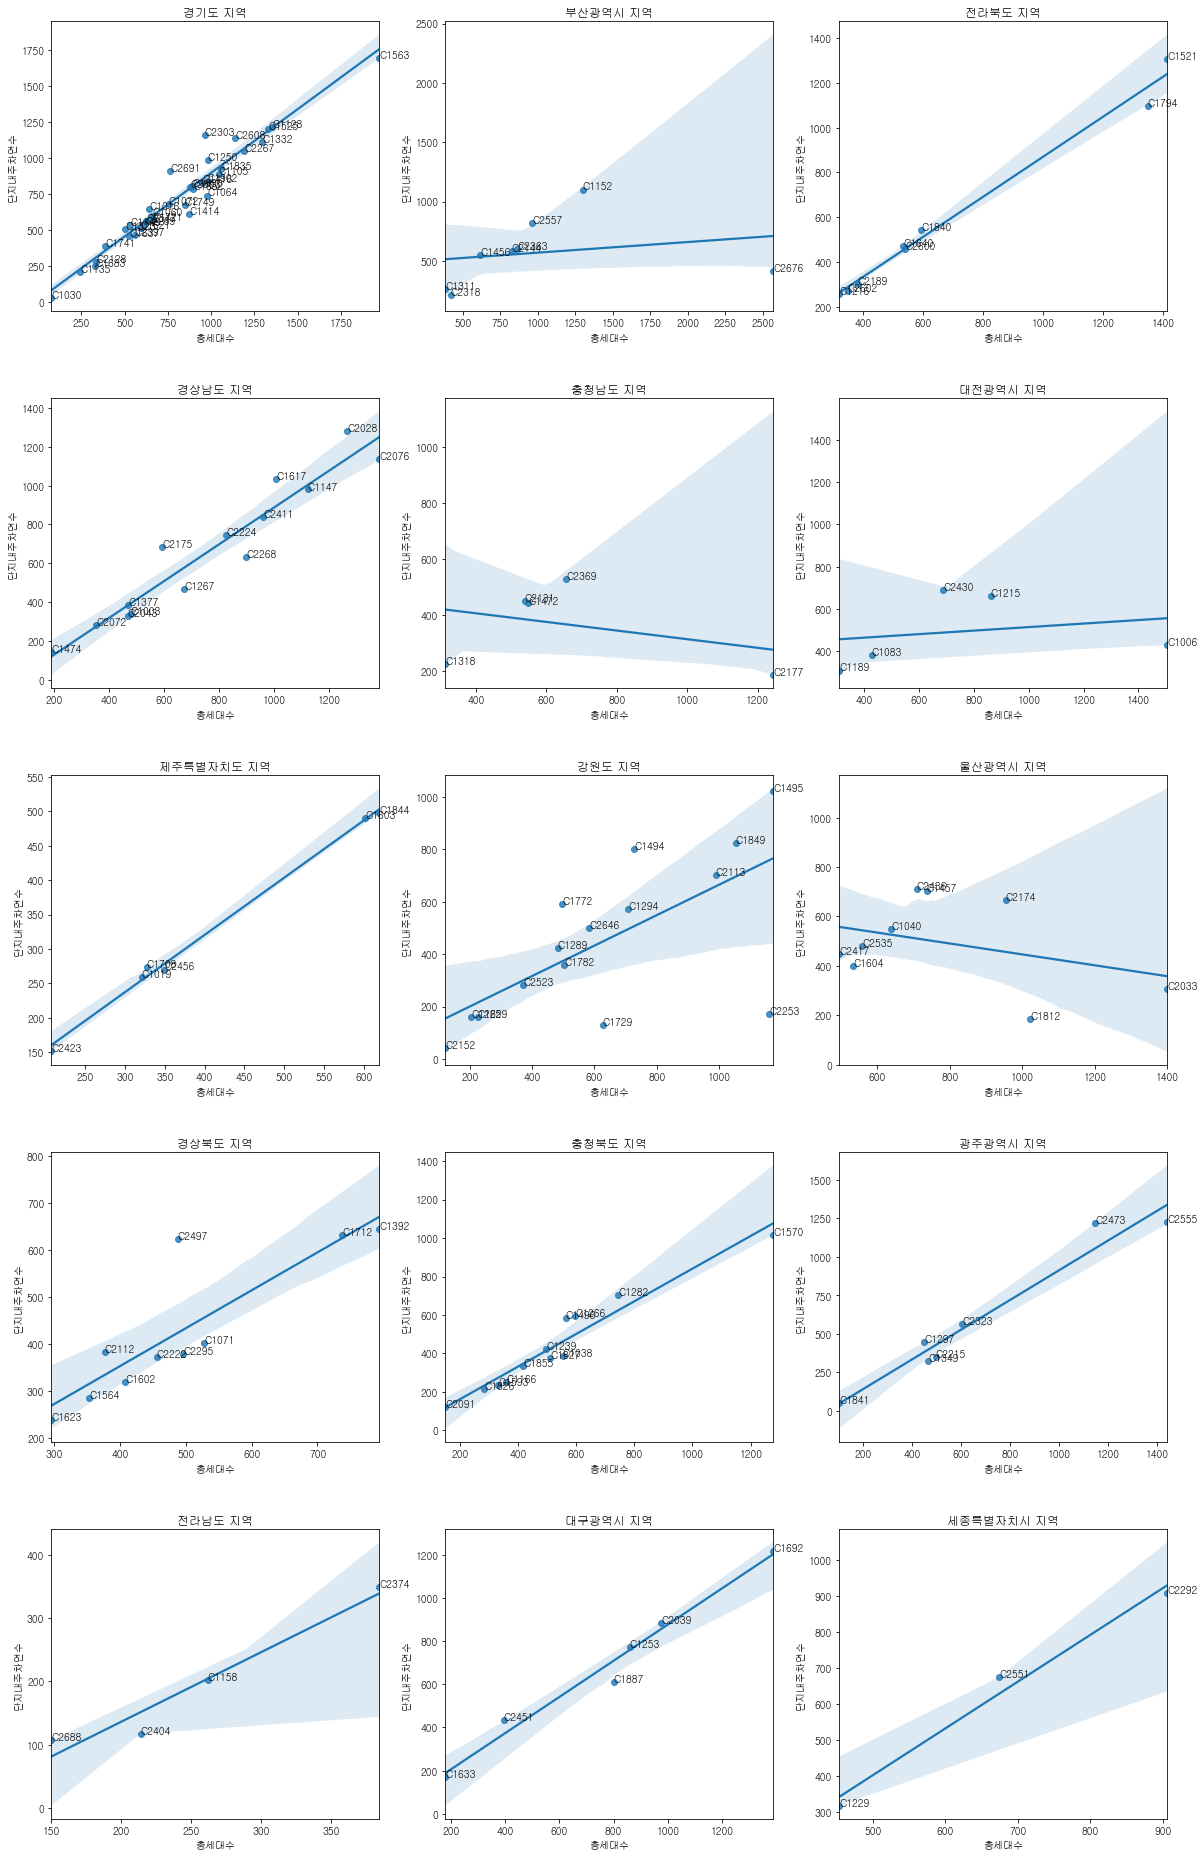

In [198]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(test_danji['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=test_danji.loc[test_danji['지역'] == n], x='총세대수', y='단지내주차면수')
    for i, code in enumerate(test_danji.loc[test_danji['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (test_danji.loc[test_danji['지역'] == n].reset_index(drop=True)['총세대수'][i],
                              test_danji.loc[test_danji['지역'] == n].reset_index(drop=True)['단지내주차면수'][i]))
    plt.title('{} 지역'.format(n))

### 산점도-지역별(건축연면적, 주차면수)

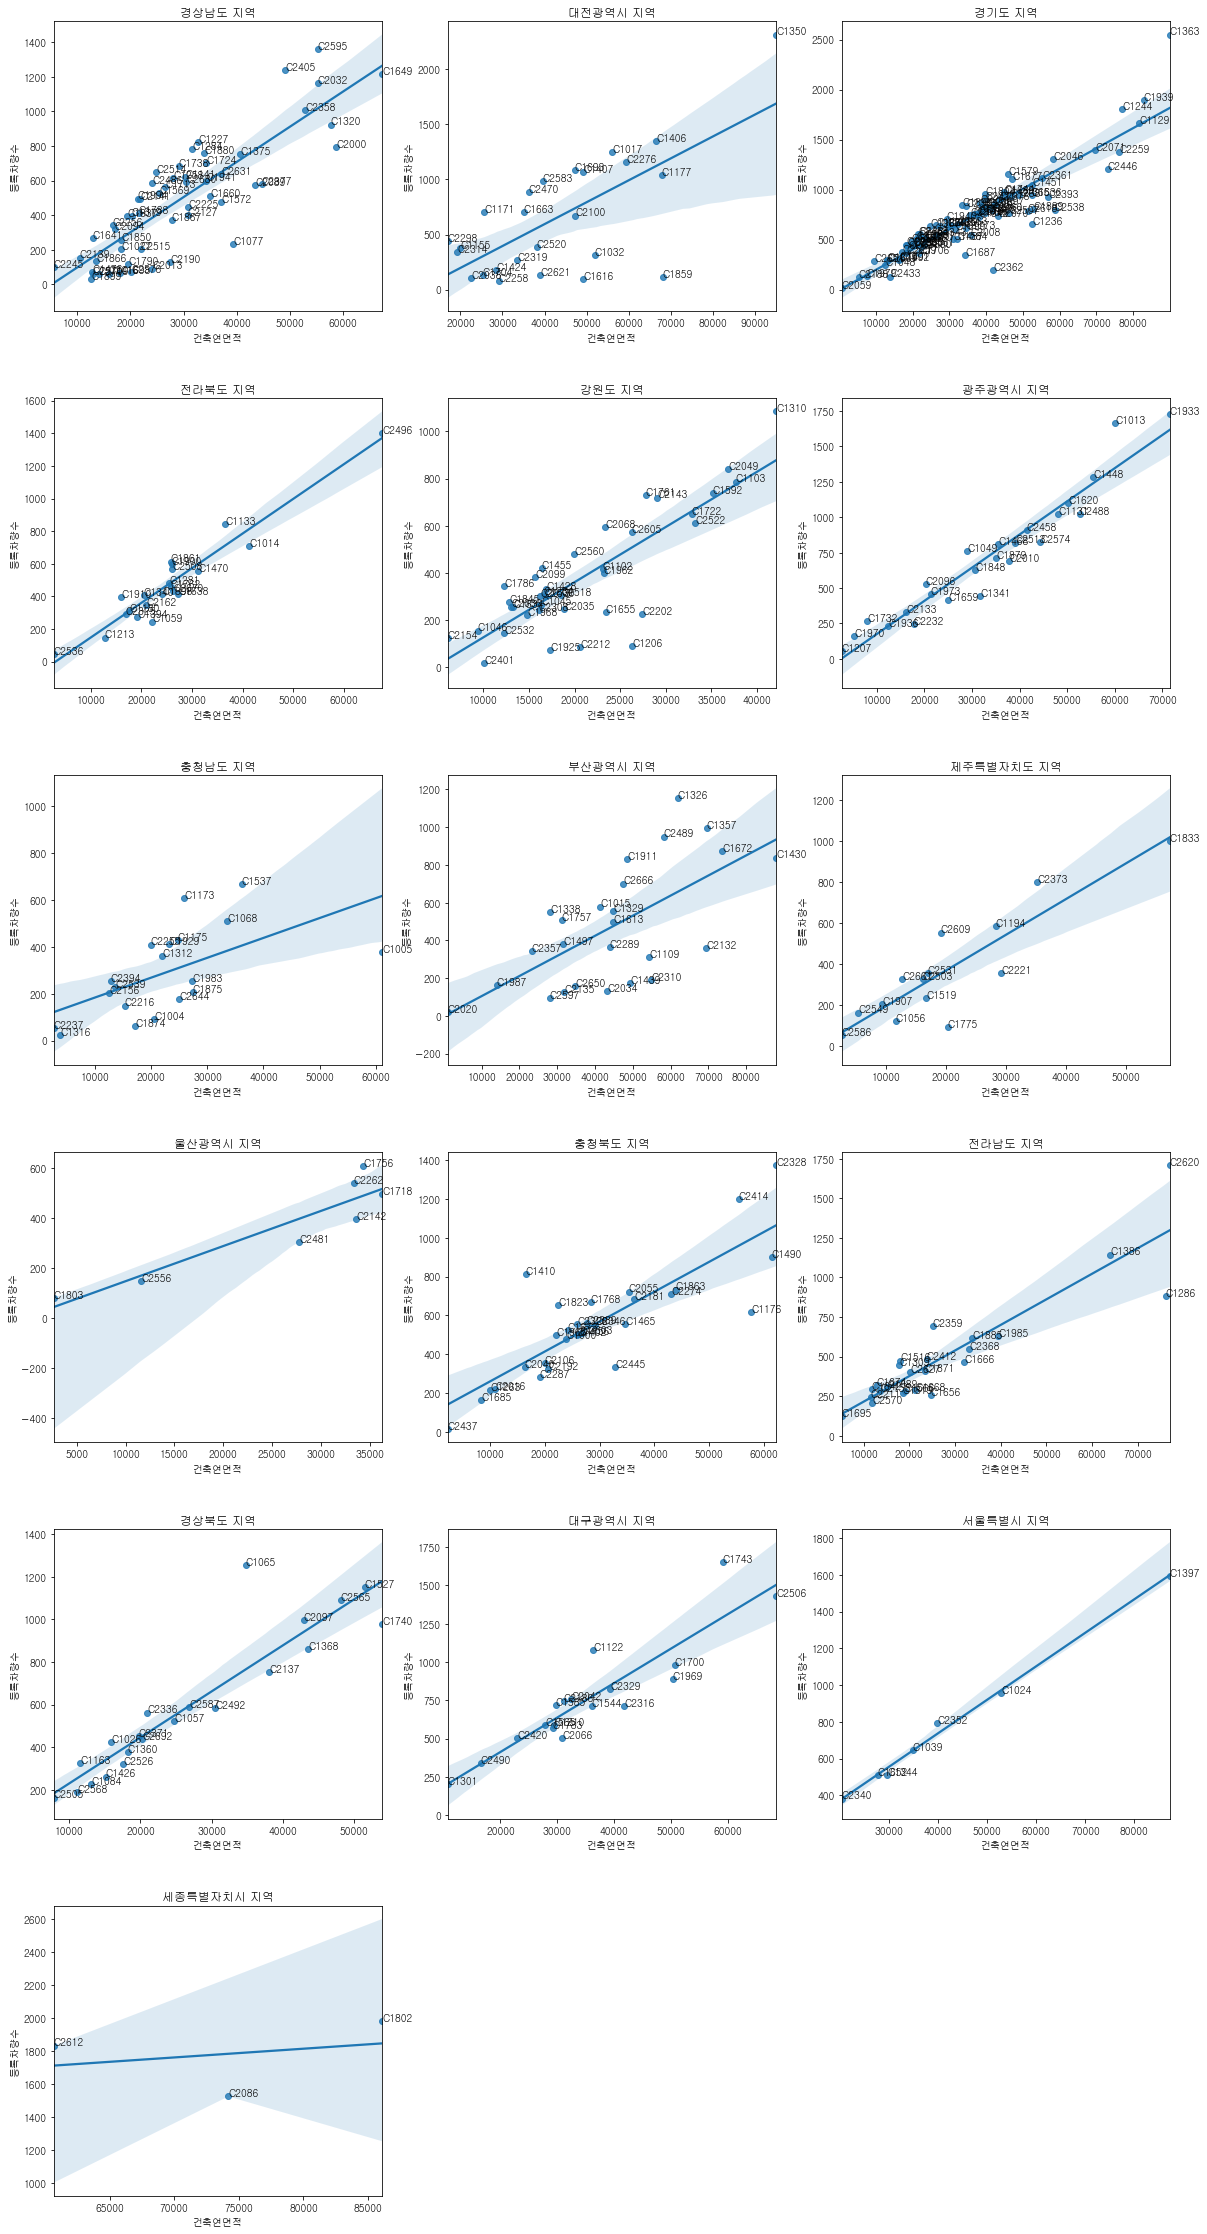

In [199]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_size['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_size.loc[train_size['지역'] == n], x='건축연면적', y='등록차량수')
    for i, code in enumerate(train_size.loc[train_size['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_size.loc[train_size['지역'] == n].reset_index(drop=True)['건축연면적'][i],
                              train_size.loc[train_size['지역'] == n].reset_index(drop=True)['등록차량수'][i]))
    plt.title('{} 지역'.format(n))

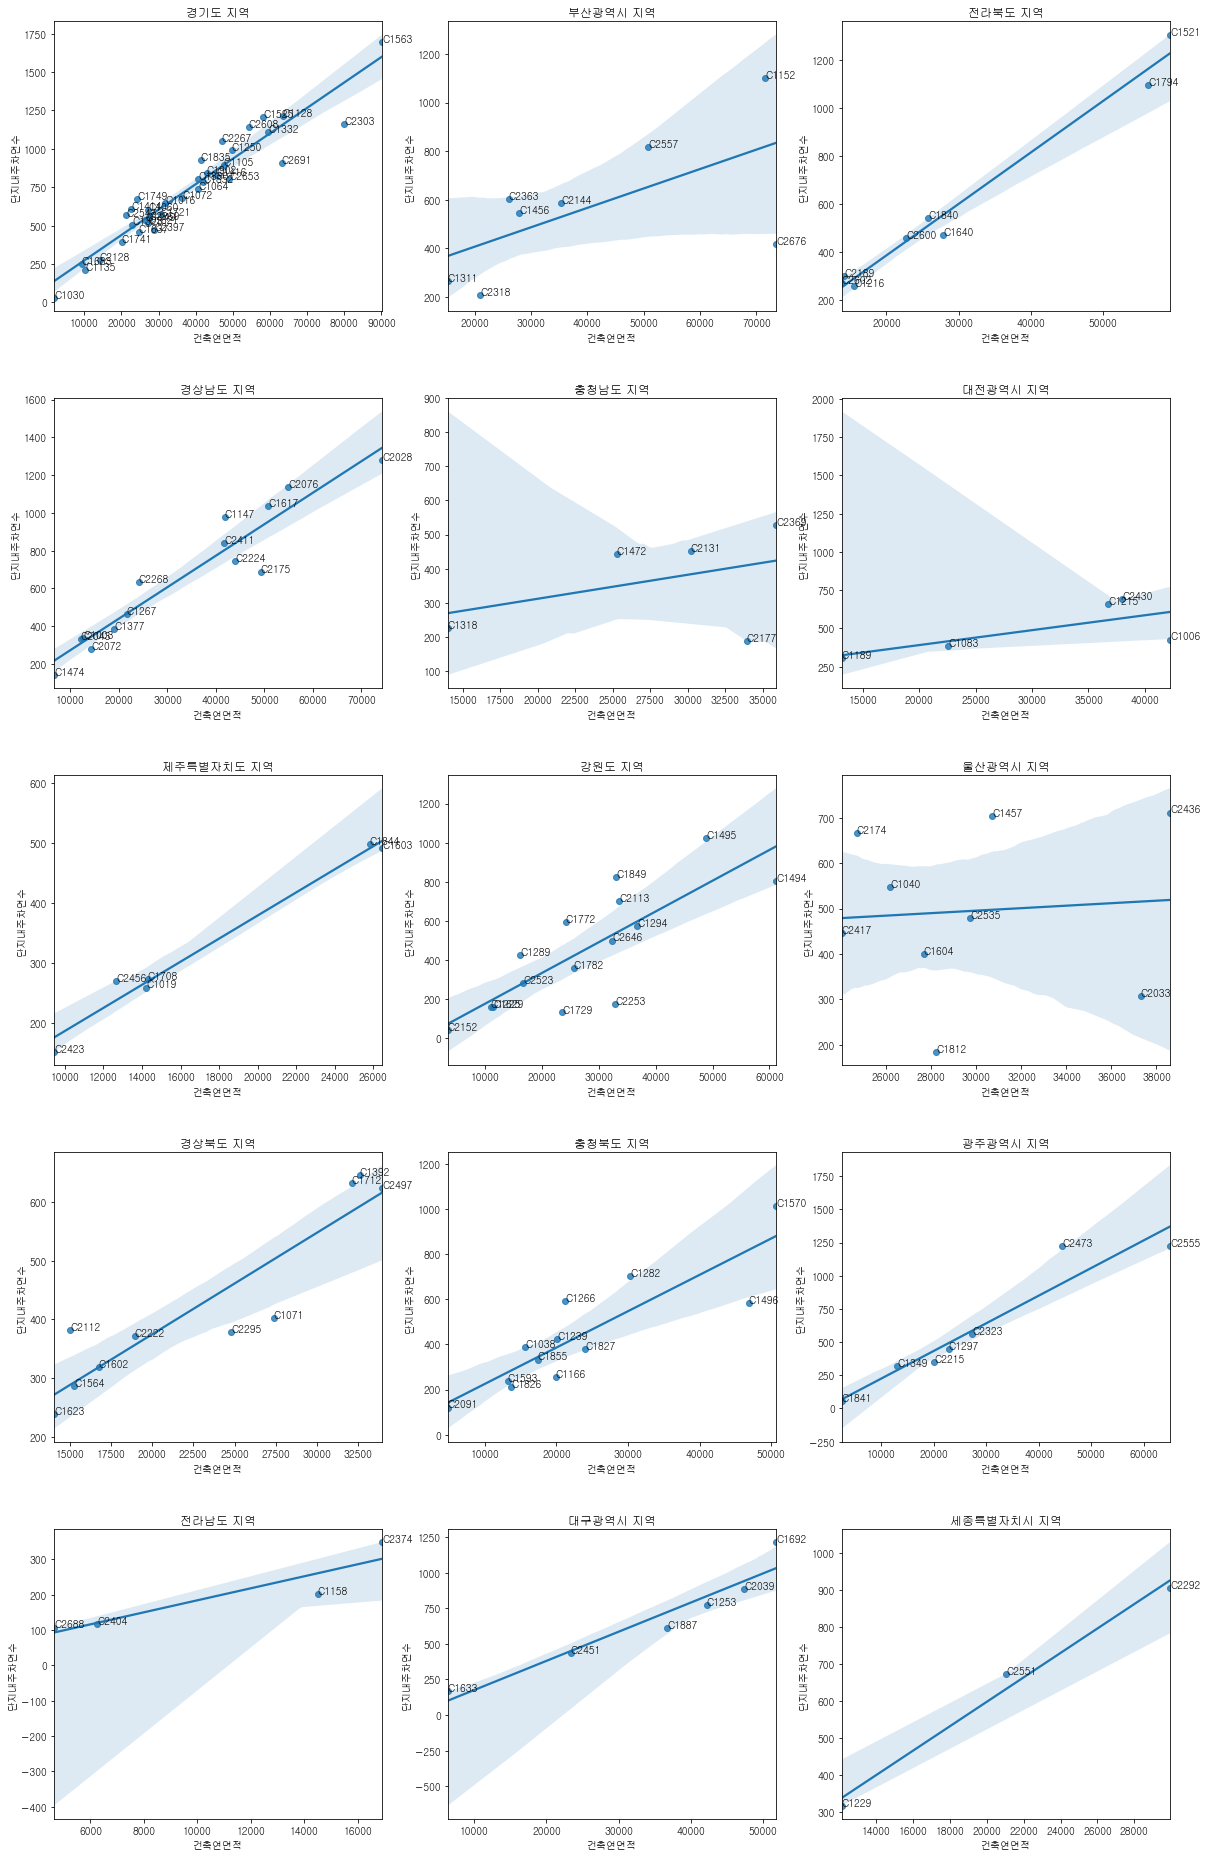

In [200]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(test_size['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=test_size.loc[test_size['지역'] == n], x='건축연면적', y='단지내주차면수')
    for i, code in enumerate(test_size.loc[test_size['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (test_size.loc[test_size['지역'] == n].reset_index(drop=True)['건축연면적'][i],
                              test_size.loc[test_size['지역'] == n].reset_index(drop=True)['단지내주차면수'][i]))
    plt.title('{} 지역'.format(n))

근데 또 예측해야 하는 단지에 비율이 맞지 않는 단지들이 존재한다는 것이죠

### 막대차트 (총세대수주차면수비 & 건축연면적주차면수비)

In [208]:
train_size['등록차량수/총세대수'] = train_size['등록차량수'] / train_size['총세대수']
train_size['등록차량수/건축연면적'] = (train_size['등록차량수'] / train_size['건축연면적']) * 100

In [209]:
train_size.nlargest(5, '등록차량수/총세대수')

단지코드  총세대수     지역   공가수  지하철   버스  단지내주차면수   등록차량수     건축연면적  주차면수/총세대수  \
193  C1410   356   충청북도  10.0  0.0  3.0    550.0   815.0  16485.44   1.544944   
314  C1743   791  대구광역시  16.0  1.0  1.0    944.0  1653.0  59167.83   1.193426   
297  C2405   600   경상남도  22.0  0.0  8.0    728.0  1240.0  49163.00   1.213333   
269  C1804   478    경기도   3.0  0.0  3.0    629.0   951.0  39754.25   1.315900   
354  C2143   363    강원도   2.0  0.0  2.0    434.0   719.0  29048.58   1.195592   

     주차면수/건축연면적  등록차량수/총세대수  등록차량수/건축연면적  
193    3.336277    2.289326     4.943756  
314    1.595462    2.089760     2.793748  
297    1.480788    2.066667     2.522222  
269    1.582221    1.989540     2.392197  
354    1.494049    1.980716     2.475164

In [210]:
train_size.nsmallest(5, '등록차량수/총세대수')

단지코드  총세대수     지역   공가수  지하철   버스  단지내주차면수  등록차량수     건축연면적  주차면수/총세대수  \
29  C1859  2424  대전광역시   1.0  1.0  4.0    487.0  116.0  68049.09   0.200908   
24  C1616  1507  대전광역시   1.0  0.0  2.0    407.0   98.0  49170.99   0.270073   
49  C1899   451   경상남도   0.0  0.0  4.0    109.0   31.0  12653.34   0.241685   
26  C2258   965  대전광역시  13.0  0.0  3.0    287.0   78.0  29065.37   0.297409   
38  C2034  1486  부산광역시   2.0  1.0  3.0    405.0  132.0  43176.91   0.272544   

    주차면수/건축연면적  등록차량수/총세대수  등록차량수/건축연면적  
29    0.715660    0.047855     0.170465  
24    0.827724    0.065030     0.199305  
49    0.861433    0.068736     0.244995  
26    0.987429    0.080829     0.268361  
38    0.938001    0.088829     0.305719

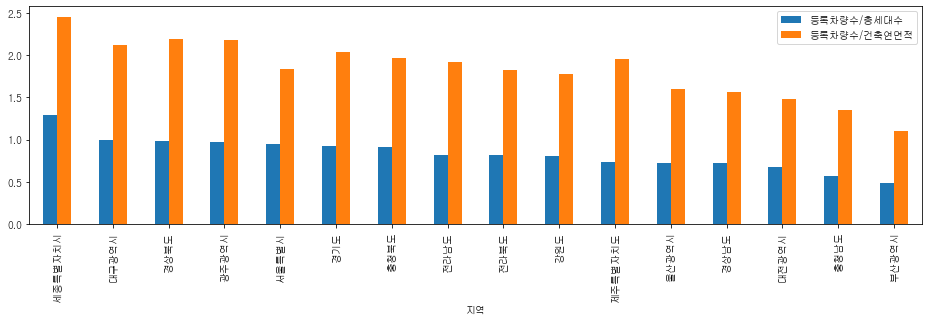

In [212]:
(train_size
 .groupby(['지역'])[['등록차량수/총세대수', '등록차량수/건축연면적']]
 .mean()
 .sort_values(by='등록차량수/총세대수', ascending=False)
 .plot(kind='bar', figsize=(16, 4)))
plt.show()

- 두 비가 다 높은 서울시는 주어진 총세대수와 건축연면적에 비해 주차면수가 높게 형성되어 있다는 뜻입니다.
- 세종은 총세대수에 대한 주차면수는 높지만, 건축연면적에 비해서는 낮습니다.
- 보통 총세대수가 많으면 건축연면적도 높습니다. 그래서 비율이 비슷하게 가는 것이 보통입니다.
- 세종같은 경우는 총세대수에 비해 건축연면적이 높은 편이라는 뜻이고, 이는 대형평형수가 많다는 의미입니다.
- 총세대수주차면수비에 비해 건축연면적주차면수비가 높은 경기도 같은 경우는 반대라는 것입니다.

In [213]:
train_size['등록차량수/총세대수'] = train_size['등록차량수'] / train_size['총세대수']
train_size['등록차량수/건축연면적'] = (train_size['등록차량수'] / train_size['건축연면적']) * 50
train_size['등록차량수/주차면수'] = train_size['등록차량수'] / train_size['단지내주차면수']

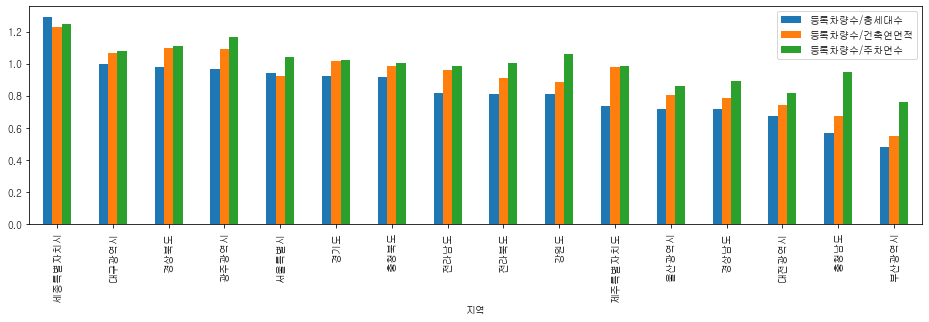

In [214]:
(train_size
 .groupby(['지역'])[['등록차량수/총세대수', '등록차량수/건축연면적', '등록차량수/주차면수']]
 .mean()
 .sort_values(by='등록차량수/총세대수', ascending=False)
 .plot(kind='bar', figsize=(16, 4)))
plt.show()

### 공급유형 바차트

공급유형을 살펴봐야겠습니다.

In [215]:
train_reqruit = pd.pivot_table(train, index='단지코드', columns='공급유형', values='전용면적별세대수', aggfunc=np.sum, fill_value=0)
train_reqruit.head()

공급유형   공공분양  공공임대(10년)  공공임대(50년)  공공임대(5년)  공공임대(분납)  국민임대  영구임대  임대상가  장기전세  \
단지코드                                                                            
C1000     0          0          0         0         0   566     0     0     0   
C1004     0          0          0         0         0     0   504    17     0   
C1005     0          0          0         0         0  1144     0     0     0   
C1013     0          0          0         0         0  1308     0     0     0   
C1014     0          0          0         0         0   996     0     0     0   

공급유형   행복주택  
단지코드         
C1000     0  
C1004     0  
C1005     0  
C1013     0  
C1014     0

In [225]:
train_reqruit2 = pd.merge(train_reqruit.reset_index(), train[['단지코드', '지역', '등록차량수']],
                          how='inner', on='단지코드').drop_duplicates().set_index('단지코드')

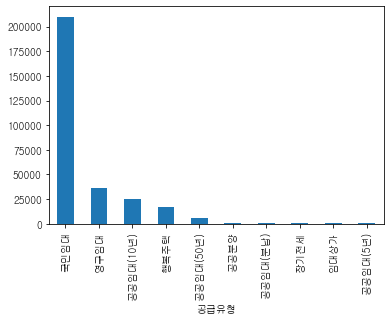

In [226]:
train_reqruit.sum(axis=0).sort_values(ascending=False).plot(kind='bar')
plt.show()

- 국민임대가 20만호가 넘으며 압도적인 비중입니다. 그 뒤로 영구임대, 공공임대, 행복주택 등이 있습니다.

In [227]:
test['공급유형'].unique()

array(['국민임대', '영구임대', '임대상가', '공공임대(50년)', '공공임대(10년)', '공공임대(분납)',
       '행복주택'], dtype=object)

In [228]:
train_reqruit2.nlargest(5, '공공분양')

공공분양  공공임대(10년)  공공임대(50년)  공공임대(5년)  공공임대(분납)  국민임대  영구임대  임대상가  장기전세  \
단지코드                                                                            
C1350   711        342          0         0       348     0     0     0     0   
C1206   267          0          0         0         0     0   478    10     0   
C2470   230          0          0       406         0     0     0     0     0   
C1000     0          0          0         0         0   566     0     0     0   
C1004     0          0          0         0         0     0   504    17     0   

       행복주택     지역   등록차량수  
단지코드                        
C1350     0  대전광역시  2315.0  
C1206     0    강원도    90.0  
C2470     0  대전광역시   887.0  
C1000     0   충청북도   481.0  
C1004     0   충청남도    93.0

In [229]:
train_reqruit2.nlargest(10, '공공임대(10년)')

공공분양  공공임대(10년)  공공임대(50년)  공공임대(5년)  공공임대(분납)  국민임대  영구임대  임대상가  장기전세  \
단지코드                                                                            
C1129     0       1444          0         0         0     0     0     0     0   
C1802     0       1438          0         0         0     0     0     0     0   
C2506     0       1124          0         0         0     0     0     0     0   
C2086     0       1080          0         0         0     0     0     0     0   
C2328     0       1077          0         0         0     0     0     0     0   
C2620     0       1029          0         0         0     0     0     0     0   
C1933     0       1022          0         0         0     0     0     0     0   
C2259     0        947          0         0         0     0     0     0     0   
C2414     0        924          0         0         0     0     0     0     0   
C1700     0        922          0         0         0     0     0     0     0   

       행복주택       지역   등록차량수  
단지코드                          
C1129     0      경기도  1668.0  
C1802     0  세종특별자치시  1983.0  
C2506     0    대구광역시  1433.0  
C2086     0  세종특별자치시  1524.0  
C2328     0     충청북도  1374.0  
C2620     0     전라남도  1709.0  
C1933     0    광주광역시  1730.0  
C2259     0      경기도  1378.0  
C2414     0     충청북도  1200.0  
C1700     0    대구광역시   979.0

In [230]:
train_reqruit2.nlargest(10, '공공임대(5년)')

공공분양  공공임대(10년)  공공임대(50년)  공공임대(5년)  공공임대(분납)  국민임대  영구임대  임대상가  장기전세  \
단지코드                                                                            
C2470   230          0          0       406         0     0     0     0     0   
C1000     0          0          0         0         0   566     0     0     0   
C1004     0          0          0         0         0     0   504    17     0   
C1005     0          0          0         0         0  1144     0     0     0   
C1013     0          0          0         0         0  1308     0     0     0   
C1014     0          0          0         0         0   996     0     0     0   
C1015     0          0          0         0         0   961     0     0     0   
C1017     0          0          0         0         0  1460     0     0     0   
C1022     0          0          0         0         0   389     0     0     0   
C1024     0        718          0         0         0     0     0     0     0   

       행복주택     지역   등록차량수  
단지코드                        
C2470     0  대전광역시   887.0  
C1000     0   충청북도   481.0  
C1004     0   충청남도    93.0  
C1005     0   충청남도   376.0  
C1013     0  광주광역시  1665.0  
C1014     0   전라북도   708.0  
C1015     0  부산광역시   579.0  
C1017     0  대전광역시  1246.0  
C1022     0    경기도   450.0  
C1024     0  서울특별시   957.0

In [231]:
train_reqruit2.nlargest(10, '공공임대(50년)')

공공분양  공공임대(10년)  공공임대(50년)  공공임대(5년)  공공임대(분납)  국민임대  영구임대  임대상가  장기전세  \
단지코드                                                                            
C2520     0          0        960         0         0     0     0     0     0   
C1497     0          0        802         0         0     0     0     0     0   
C1424     0          0        624         0         0     0     0     0     0   
C2202     0          0        623         0         0     0     0     0     0   
C2221     0          0        590         0         0     0     0     0     0   
C2340     0          0        512         0         0     0     0     0     0   
C1722     0          0        505         0         0     0   298     6     0   
C2216     0          0        390         0         0     0     0     0     0   
C2644     0          0        387         0         0     0   388     3     0   
C1850     0          0        385         0         0     0     0     0     0   

       행복주택       지역  등록차량수  
단지코드                         
C2520     0    대전광역시  386.0  
C1497     0    부산광역시  382.0  
C1424     0    대전광역시  179.0  
C2202     0      강원도  226.0  
C2221     0  제주특별자치도  359.0  
C2340     0    서울특별시  382.0  
C1722     0      강원도  649.0  
C2216     0     충청남도  149.0  
C2644     0     충청남도  177.0  
C1850     0     경상남도  254.0

In [232]:
req_cols = ['공공분양', '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)',
       '영구임대', '임대상가', '장기전세', '행복주택']

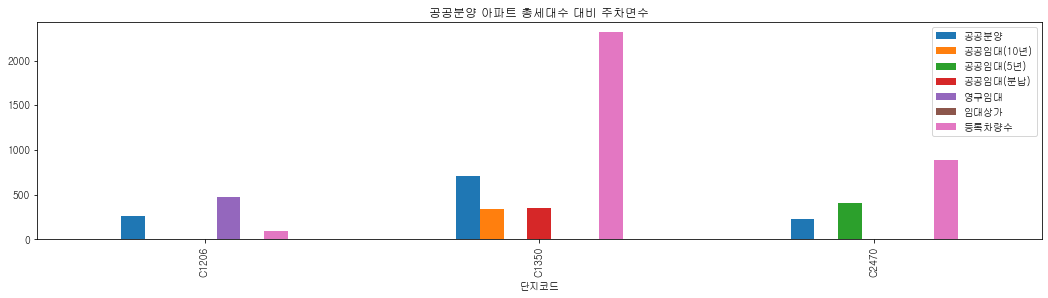

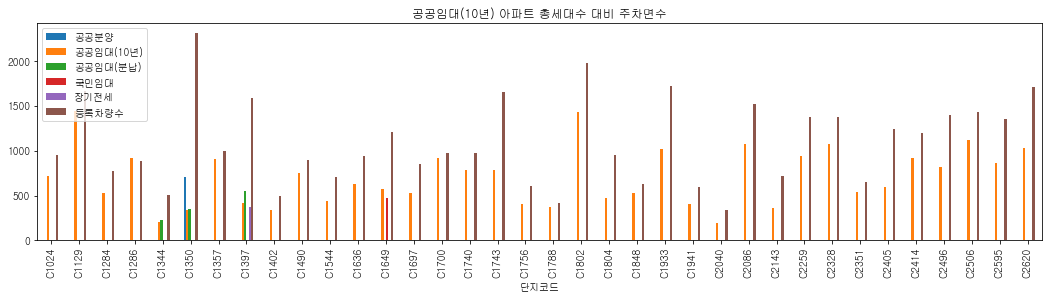

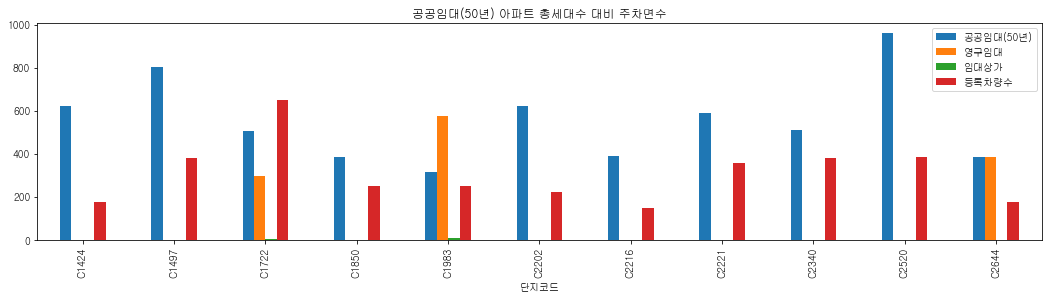

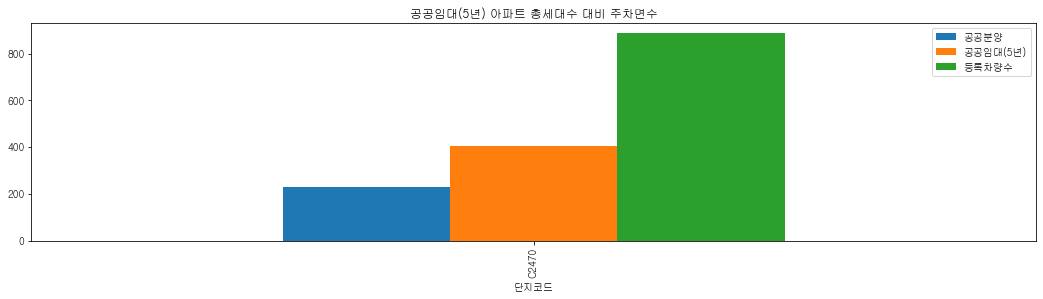

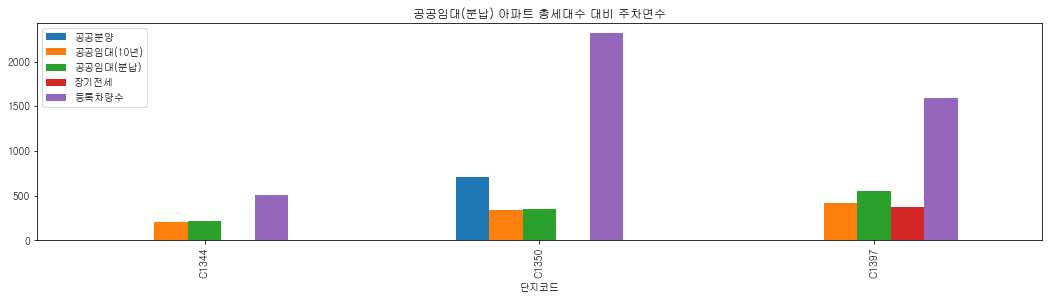

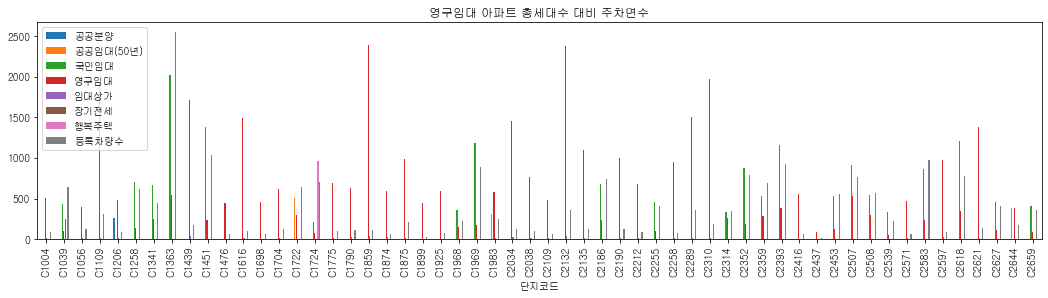

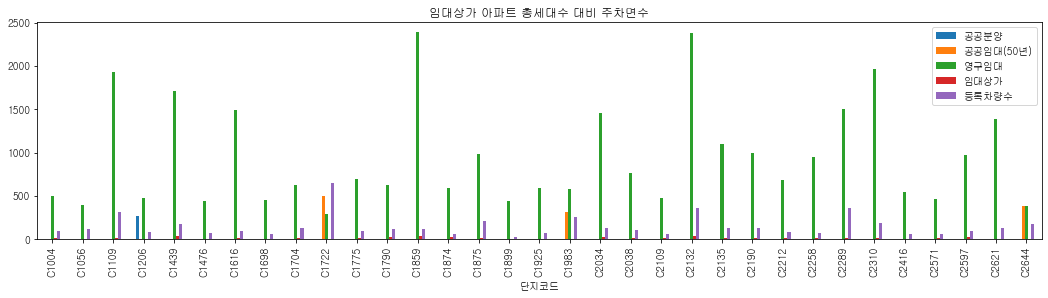

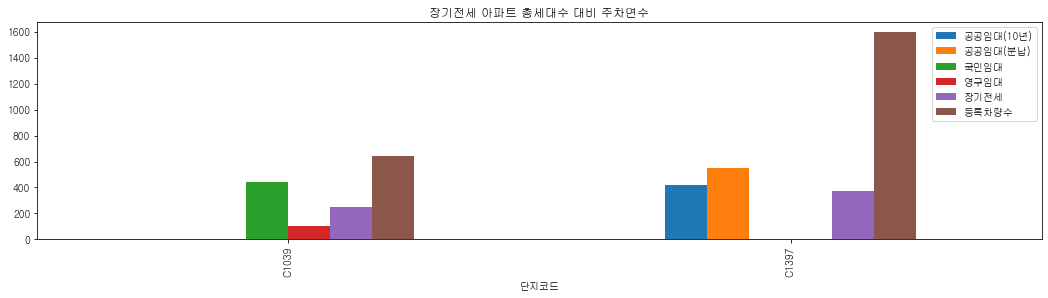

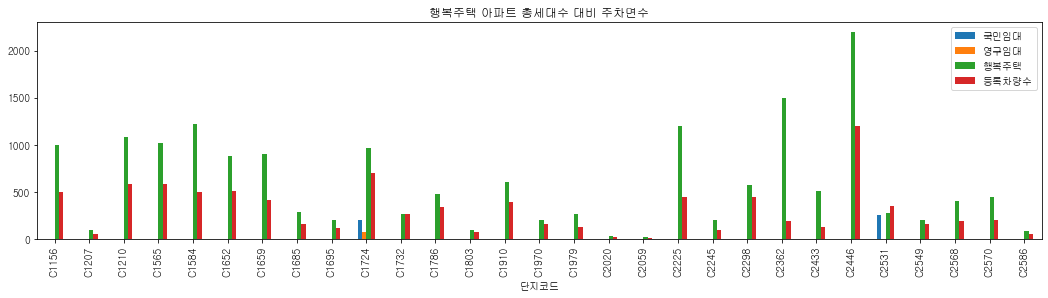

In [233]:
for col in req_cols:
    train_reqruit2.loc[train_reqruit2[col] != 0,
                      [x for x in train_reqruit2.columns if train_reqruit2.loc[train_reqruit2[col] != 0][x].sum() != 0]].plot(kind='bar', figsize=(18, 4))
    plt.title('{} 아파트 총세대수 대비 주차면수'.format(col))
    plt.show()

- 특이한 점이 많습니다.
1. 임대상가가 있는 아파트는 무조건 영구임대단지다. 총세대수에 비해 주차면수도 굉장히 적다.
2. 공공임대(50년)이 있는 단지는 주차면수가 총세대수에 비해 굉장히 적다.
3. 행복주택은 보통 행복주택만 있습니다.
4. 공공분양, 공공임대(5년), 장기전세는 단지가 너무 없습니다.

In [234]:
train_reqruit2.nlargest(10, '임대상가')

공공분양  공공임대(10년)  공공임대(50년)  공공임대(5년)  공공임대(분납)  국민임대  영구임대  임대상가  장기전세  \
단지코드                                                                            
C1439     0          0          0         0         0     0  1710    45     0   
C2132     0          0          0         0         0     0  2385    43     0   
C1859     0          0          0         0         0     0  2389    35     0   
C1790     0          0          0         0         0     0   627    30     0   
C2597     0          0          0         0         0     0   976    29     0   
C1874     0          0          0         0         0     0   592    27     0   
C2034     0          0          0         0         0     0  1460    26     0   
C1109     0          0          0         0         0     0  1937    20     0   
C2289     0          0          0         0         0     0  1507    20     0   
C2310     0          0          0         0         0     0  1968    20     0   

       행복주택     지역  등록차량수  
단지코드                       
C1439     0  부산광역시  172.0  
C2132     0  부산광역시  359.0  
C1859     0  대전광역시  116.0  
C1790     0   경상남도  120.0  
C2597     0  부산광역시   94.0  
C1874     0   충청남도   62.0  
C2034     0  부산광역시  132.0  
C1109     0  부산광역시  313.0  
C2289     0  부산광역시  364.0  
C2310     0  부산광역시  189.0

### 자격유형 바차트

In [235]:
train_qual = pd.pivot_table(train, index='단지코드', columns='자격유형', values='전용면적별세대수', aggfunc=np.sum, fill_value=0)
train_qual.head()

자격유형      A  B    C   D  E  F  G  H  I  J  K  L  M  N  O
단지코드                                                    
C1000   566  0    0   0  0  0  0  0  0  0  0  0  0  0  0
C1004     0  0  504  17  0  0  0  0  0  0  0  0  0  0  0
C1005  1144  0    0   0  0  0  0  0  0  0  0  0  0  0  0
C1013  1308  0    0   0  0  0  0  0  0  0  0  0  0  0  0
C1014   996  0    0   0  0  0  0  0  0  0  0  0  0  0  0

In [236]:
train_qual2 = pd.merge(train_qual.reset_index(),
                       train[['단지코드', '지역', '등록차량수']],
                       how='inner', on='단지코드').drop_duplicates().set_index('단지코드')

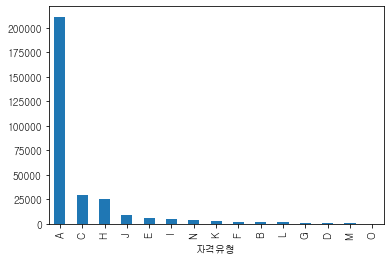

In [237]:
train_qual.sum(axis=0).sort_values(ascending=False).plot(kind='bar')
plt.show()

- A가 압도적으로 많습니다. C, H가 뒤를 잇습니다.

In [238]:
qual_cols = ['C', 'D', 'E', 'H', 'I', 'J', 'K', 'L']
qual_cols2 = ['M', 'N', 'O', 'F', 'B', 'G']

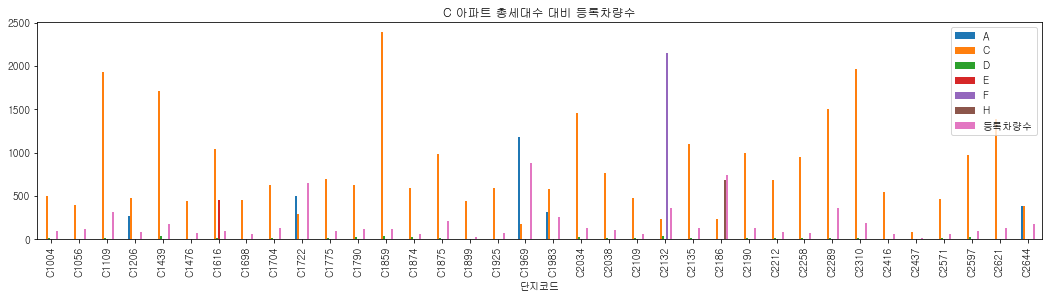

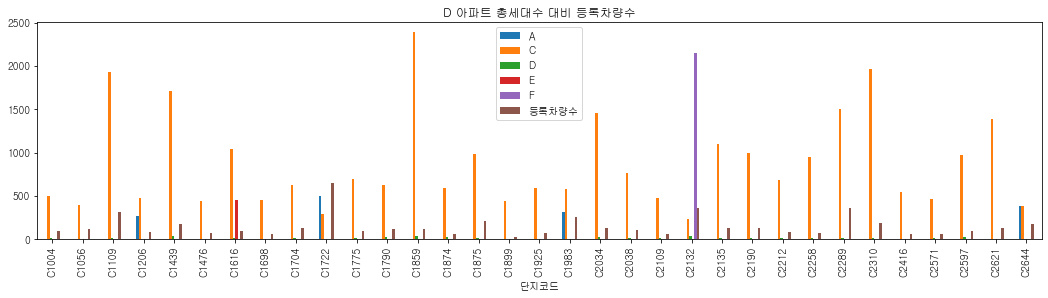

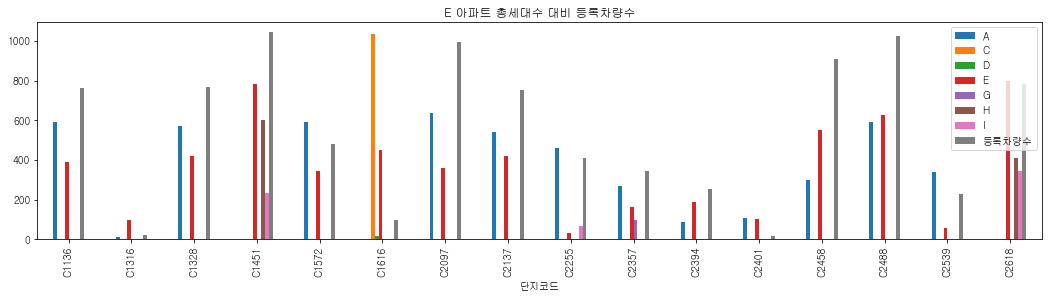

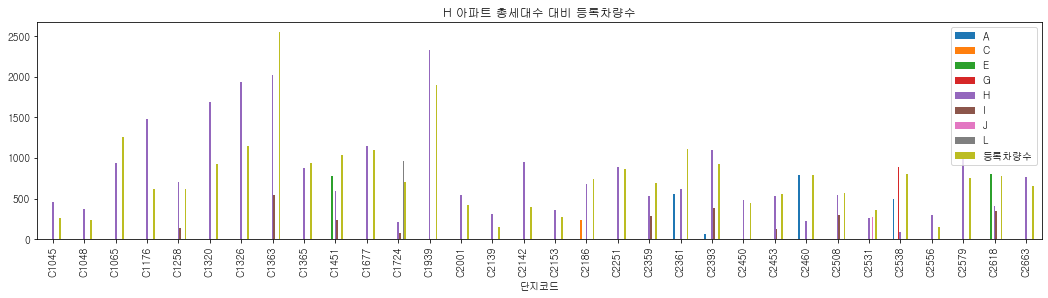

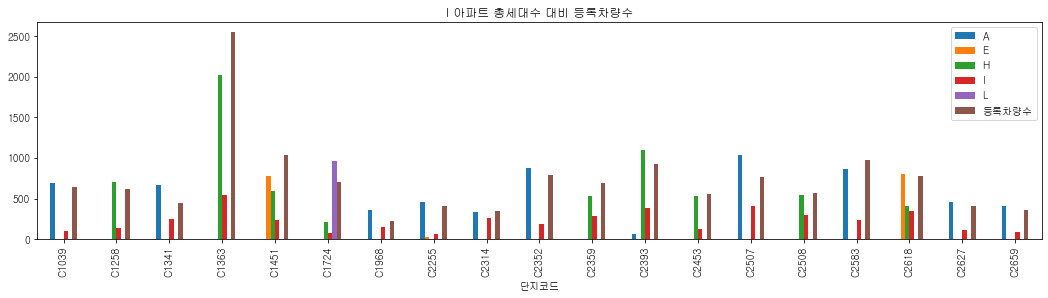

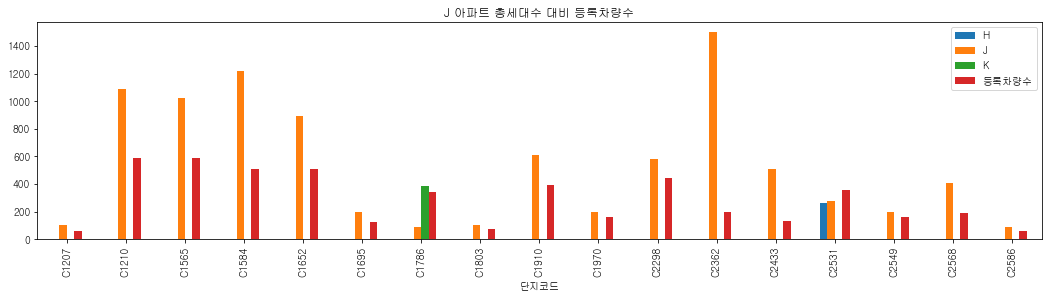

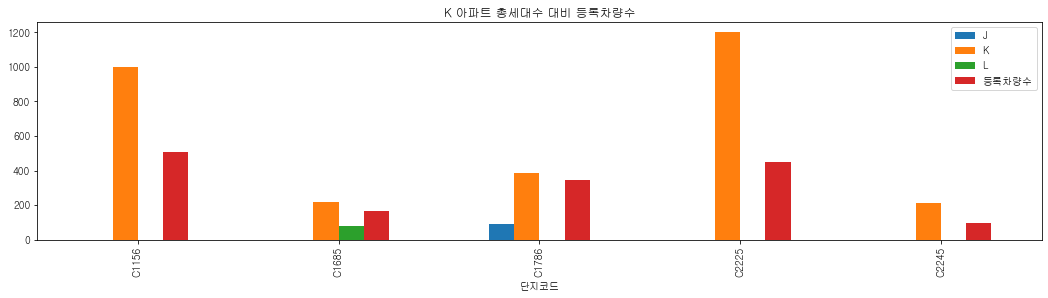

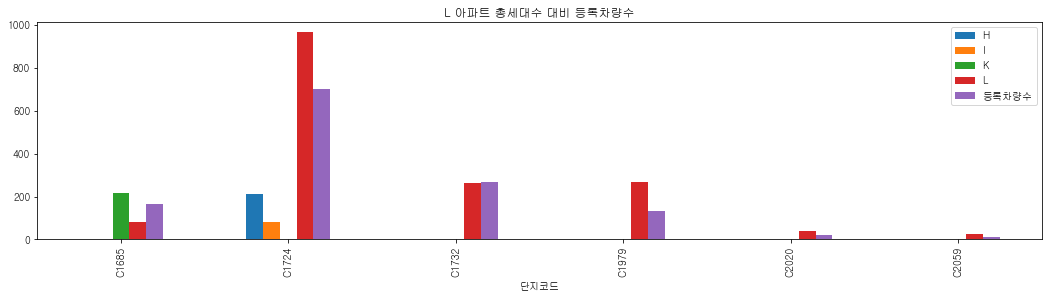

In [242]:
for col in qual_cols:
    train_qual2.loc[train_qual2[col] != 0,
                      [x for x in train_qual2.columns if train_qual2.loc[train_qual2[col] != 0][x].sum() != 0]].plot(kind='bar', figsize=(18, 4))
    plt.title('{} 아파트 총세대수 대비 등록차량수'.format(col))
    plt.show()

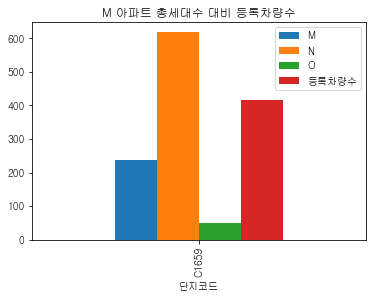

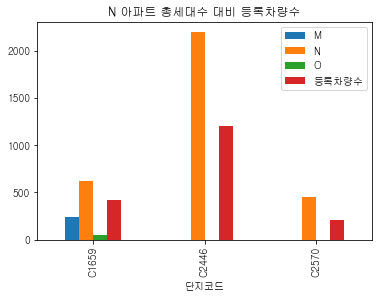

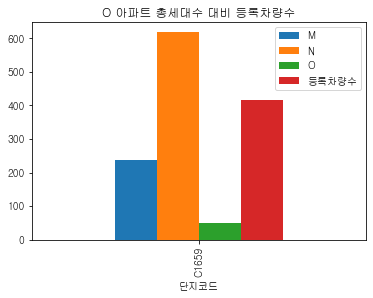

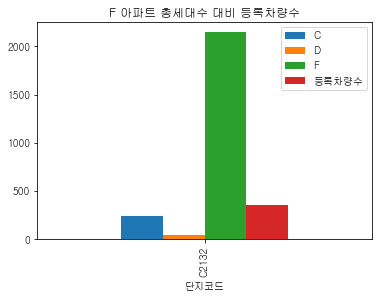

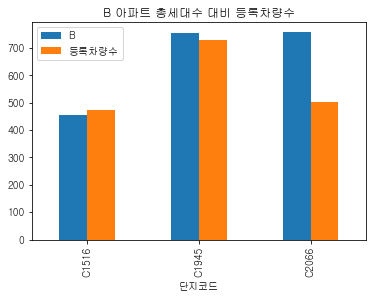

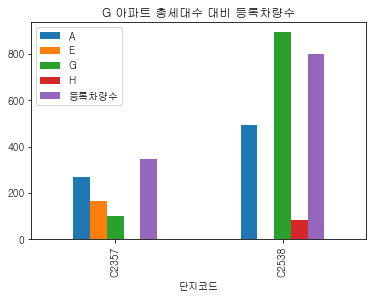

In [241]:
for col in qual_cols2:
    train_qual2.loc[train_qual2[col] != 0,
                      [x for x in train_qual2.columns if train_qual2.loc[train_qual2[col] != 0][x].sum() != 0]].plot(kind='bar', figsize=(6, 4))
    plt.title('{} 아파트 총세대수 대비 등록차량수'.format(col))
    plt.show()

In [243]:
train_req_qual = pd.merge(train_qual, train_reqruit2.reset_index(), how='inner', on='단지코드').drop_duplicates().set_index('단지코드')
train_req_qual.head()

A  B    C   D  E  F  G  H  I  J  K  L  M  N  O  공공분양  공공임대(10년)  \
단지코드                                                                        
C1000   566  0    0   0  0  0  0  0  0  0  0  0  0  0  0     0          0   
C1004     0  0  504  17  0  0  0  0  0  0  0  0  0  0  0     0          0   
C1005  1144  0    0   0  0  0  0  0  0  0  0  0  0  0  0     0          0   
C1013  1308  0    0   0  0  0  0  0  0  0  0  0  0  0  0     0          0   
C1014   996  0    0   0  0  0  0  0  0  0  0  0  0  0  0     0          0   

       공공임대(50년)  공공임대(5년)  공공임대(분납)  국민임대  영구임대  임대상가  장기전세  행복주택     지역  \
단지코드                                                                        
C1000          0         0         0   566     0     0     0     0   충청북도   
C1004          0         0         0     0   504    17     0     0   충청남도   
C1005          0         0         0  1144     0     0     0     0   충청남도   
C1013          0         0         0  1308     0     0     0     0  광주광역시   
C1014          0         0         0   996     0     0     0     0   전라북도   

        등록차량수  
단지코드           
C1000   481.0  
C1004    93.0  
C1005   376.0  
C1013  1665.0  
C1014   708.0

In [244]:
for col in req_cols:
    print(col)
    print(tabulate(train_req_qual.loc[train_req_qual[col] != 0,
                                      [x for x in train_req_qual.columns if train_req_qual.loc[train_req_qual[col] != 0][x].sum() != 0]],
                  headers='keys', tablefmt='psql'))
    print("")

공공분양
+------------+------+-----+-----+------------+------------------+-----------------+------------------+------------+------------+------------+--------------+
| 단지코드   |    A |   C |   D |   공공분양 |   공공임대(10년) |   공공임대(5년) |   공공임대(분납) |   영구임대 |   임대상가 | 지역       |   등록차량수 |
|------------+------+-----+-----+------------+------------------+-----------------+------------------+------------+------------+------------+--------------|
| C1206      |  267 | 478 |  10 |        267 |                0 |               0 |                0 |        478 |         10 | 강원도     |           90 |
| C1350      | 1401 |   0 |   0 |        711 |              342 |               0 |              348 |          0 |          0 | 대전광역시 |         2315 |
| C2470      |  636 |   0 |   0 |        230 |                0 |             406 |                0 |          0 |          0 | 대전광역시 |          887 |
+------------+------+-----+-----+------------+------------------+-----------------+------------------+---

In [143]:
for col in ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']:
    print(col)
    print(tabulate(train_req_qual.loc[train_req_qual[col] != 0,
                                      [x for x in train_req_qual.columns if train_req_qual.loc[train_req_qual[col] != 0][x].sum() != 0]],
                  headers='keys', tablefmt='psql'))
    print("")

B
+------------+-----+------------+------------+------------------+
| 단지코드   |   B |   국민임대 | 지역       |   단지내주차면수 |
|------------+-----+------------+------------+------------------|
| C1516      | 456 |        456 | 전라남도   |              367 |
| C1945      | 755 |        755 | 경기도     |              734 |
| C2066      | 757 |        757 | 대구광역시 |              660 |
+------------+-----+------------+------------+------------------+

C
+------------+------+------+-----+-----+------+-----+------------------+------------+------------+------------+----------------+------------------+
| 단지코드   |    A |    C |   D |   E |    F |   H |   공공임대(50년) |   국민임대 |   영구임대 |   임대상가 | 지역           |   단지내주차면수 |
|------------+------+------+-----+-----+------+-----+------------------+------------+------------+------------+----------------+------------------|
| C1004      |    0 |  504 |  17 |   0 |    0 |   0 |                0 |          0 |        504 |         17 | 충청남도       |              153 |
| C1

### 지역별로, 자격유형별 평균 임대료를 살펴봐야겠습니다.

In [245]:
mean_rent = train.groupby(['지역', '자격유형'])[['면적당임대료']].mean().reset_index()

In [246]:
mean_rent = mean_rent.loc[mean_rent['면적당임대료'] != 0]

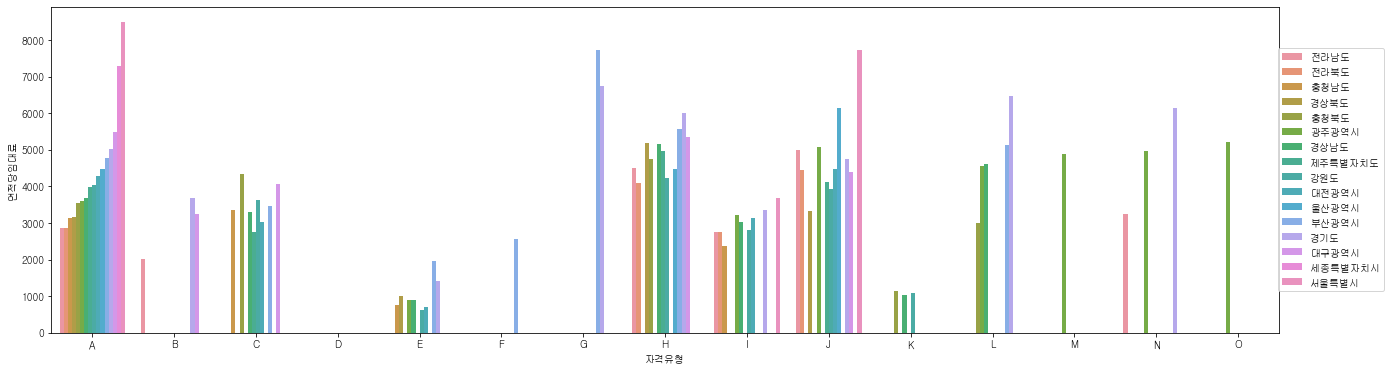

In [247]:
plt.figure(figsize=(22, 6))
sns.barplot(data=mean_rent.sort_values(by=['자격유형', '면적당임대료']),
            x='자격유형', y='면적당임대료', hue='지역')
plt.legend(loc='right', bbox_to_anchor=(1.09, 0.5))
plt.show()

- A, J, G 는 꽤나 높게 형성됩니다.
- 그러나 E, K 는 꽤나 낮게 형성됩니다.

In [248]:
kookmin_A = (
    train
    .loc[(train['공급유형'] == '국민임대') & (train['자격유형'] == 'A')]
    .groupby(['지역'])['면적당임대료']
    .mean()
    .sort_values(ascending=False)
    .to_frame()
)
kookmin_A

면적당임대료
지역                  
서울특별시    7487.593573
세종특별자치시  5321.380731
경기도      4850.398017
부산광역시    4641.213217
대구광역시    4272.213051
대전광역시    4084.761630
강원도      3940.679162
제주특별자치도  3787.516145
울산광역시    3597.719743
경상남도     3354.302561
충청북도     3103.855208
광주광역시    3058.832986
충청남도     3032.201320
경상북도     3004.303929
전라북도     2688.863480
전라남도     2542.644441

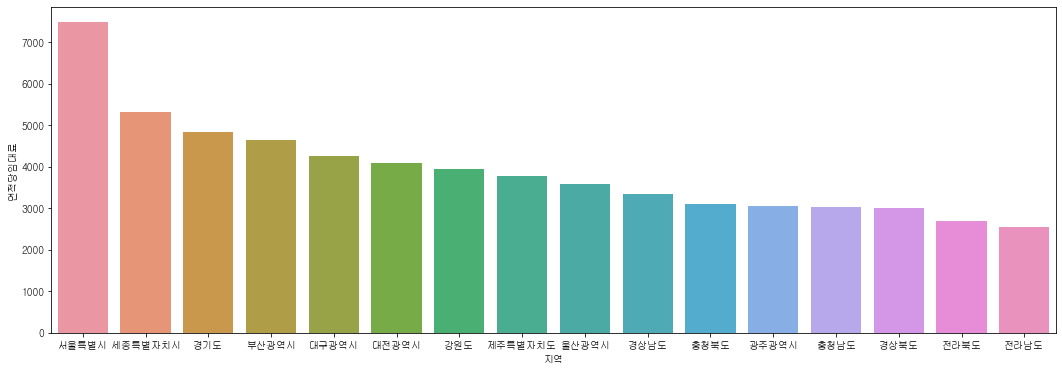

In [249]:
plt.figure(figsize=(18, 6))
sns.barplot(data=kookmin_A, x=kookmin_A.index, y='면적당임대료')
plt.show()

- 국민임대일반지수를 만들어줄 수도 있을 것 같습니다. 표준화를 통해서..
- 지역별 국민임대, A 의 평균 면적당 임대료를 수치로 넣어주면, 해당 지역의 보통의 지가의 수치를 대변할 수 있을 것도 같습니다.
- 문제는 강원도가 상당히 높은 게 이상합니다.

In [250]:
mean_ = kookmin_A['면적당임대료'].mean()
std_ = kookmin_A['면적당임대료'].std()
kookmin_A['국민임대일반지수'] = (kookmin_A['면적당임대료'] - mean_) / std_

In [251]:
kookmin_A

면적당임대료  국민임대일반지수
지역                            
서울특별시    7487.593573  2.871321
세종특별자치시  5321.380731  1.126397
경기도      4850.398017  0.747012
부산광역시    4641.213217  0.578510
대구광역시    4272.213051  0.281273
대전광역시    4084.761630  0.130278
강원도      3940.679162  0.014217
제주특별자치도  3787.516145 -0.109159
울산광역시    3597.719743 -0.262043
경상남도     3354.302561 -0.458120
충청북도     3103.855208 -0.659860
광주광역시    3058.832986 -0.696126
충청남도     3032.201320 -0.717579
경상북도     3004.303929 -0.740051
전라북도     2688.863480 -0.994144
전라남도     2542.644441 -1.111926

In [252]:
mean_rent = train.groupby(['지역', '자격유형'])[['면적당임대료']].mean().reset_index()

In [253]:
# 자격유형이 존재하지 않는 지역이 있는데, 0 으로 동일하게 넣어주겠습니다. 원활한 시각화를 위해.
for region in list(mean_rent['지역'].unique()):
    for qual in list(mean_rent['자격유형'].unique()):
        if len(mean_rent.loc[(mean_rent['지역'] == region) & (mean_rent['자격유형'] == qual)]) == 0:
            mean_rent = mean_rent.append({'지역': region, '자격유형': qual, '면적당임대료': 0}, ignore_index=True)
        else:
            pass

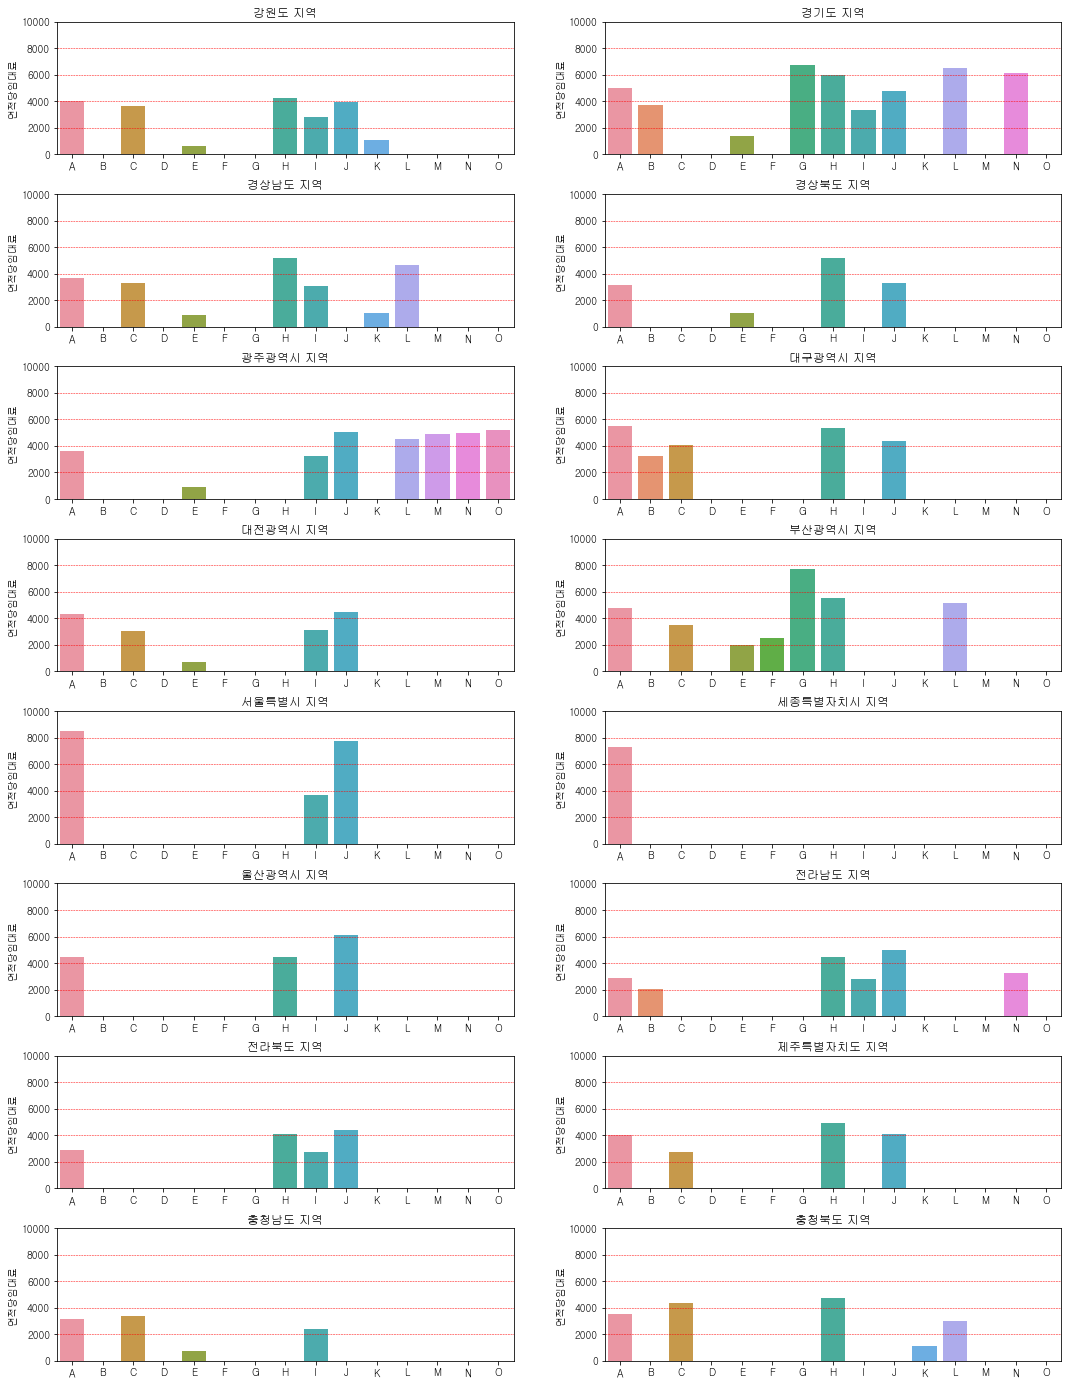

In [254]:
# 지역별로 임대료를 자격유형을 기준, 상대적으로 살펴보기 위함입니다.

fig = plt.figure(figsize=(18, 50))
for i, n in enumerate(list(mean_rent['지역'].unique())):
    plt.subplot(16, 2, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.barplot(data=mean_rent.loc[mean_rent['지역'] == n].sort_values('자격유형'), x='자격유형', y='면적당임대료')
    plt.ylim(top = 10000)
    plt.axhline(y = 2000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 4000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 6000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 8000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.xlabel('')
    plt.title('{} 지역'.format(n))

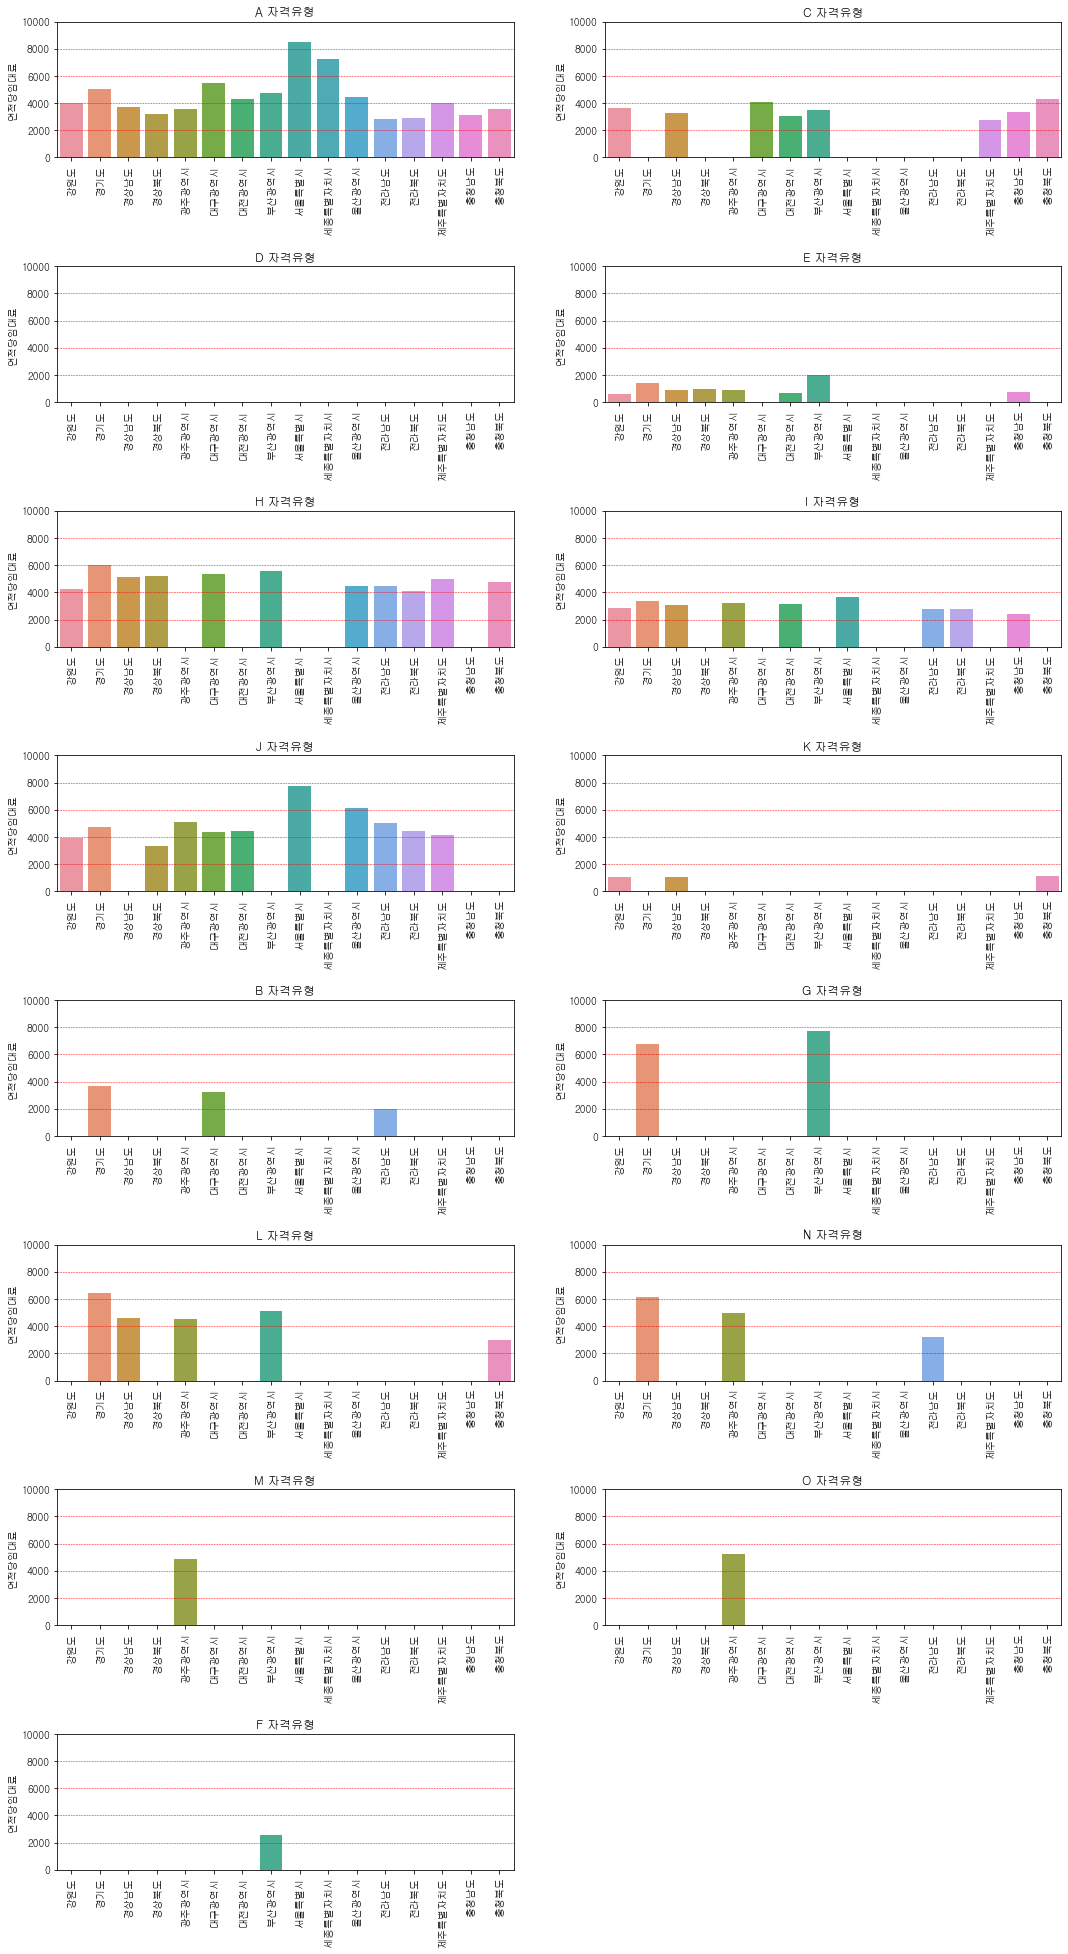

In [255]:
# 지역별로 임대료를 자격유형을 기준, 상대적으로 살펴보기 위함입니다.

fig = plt.figure(figsize=(18, 70))
for i, n in enumerate(list(mean_rent['자격유형'].unique())):
    plt.subplot(16, 2, i+1)
    plt.subplots_adjust(hspace=0.8)
    plots = sns.barplot(data=mean_rent.loc[mean_rent['자격유형'] == n].sort_values('지역'),
                        x='지역', y='면적당임대료')
    plt.ylim(top = 10000)
    plt.axhline(y = 2000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 4000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 6000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.axhline(y = 8000, color = 'r', linestyle = '--', linewidth = 0.5)
    plt.xlabel('')
    plt.xticks(rotation=90)
    plt.title('{} 자격유형'.format(n))

- E, K 는 도대체 무엇이길래 모든 지역에서 낮게 형성되는가?
- I도 상대적으로 낮다. 왜 그럴까?

- 확실히 보면, 자격유형이 임대료에 상당히 많은 영향을 미치며, 공급유형이 대체로 자격유형과 연관이 있습니다.
- 동일 단지라고 해서 임대료가 비슷하지가 않습니다.
- 차라리 해당 자격유형의 임대료를 평균으로 산정하고, 국민임대일반지수를 곱해주는 것이 더 나을 수도 있을 것 같습니다.

### 단지의 총 환산보증금이 단지의 특성을 대변할 수 있을까?

In [256]:
train['세대수X환산보증금'] = train['전용면적별세대수'] * train['환산보증금']
test['세대수X환산보증금'] = test['전용면적별세대수'] * test['환산보증금']

In [258]:
train_depot = pd.merge(train_danji, train.groupby(['단지코드'])['세대수X환산보증금'].sum().reset_index(),
                       how='inner', on='단지코드')

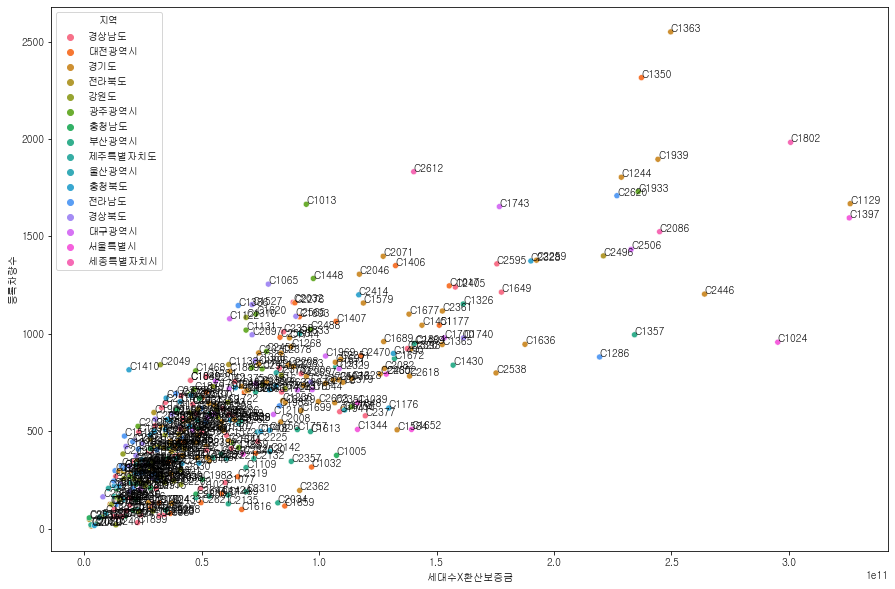

In [259]:
plt.figure(figsize=(15, 10))
plots = sns.scatterplot(data=train_depot, x='세대수X환산보증금', y='등록차량수', hue='지역')
for i, code in enumerate(train_depot['단지코드']):
    plots.annotate(code, (train_depot['세대수X환산보증금'][i], train_depot['등록차량수'][i]))
plt.show()

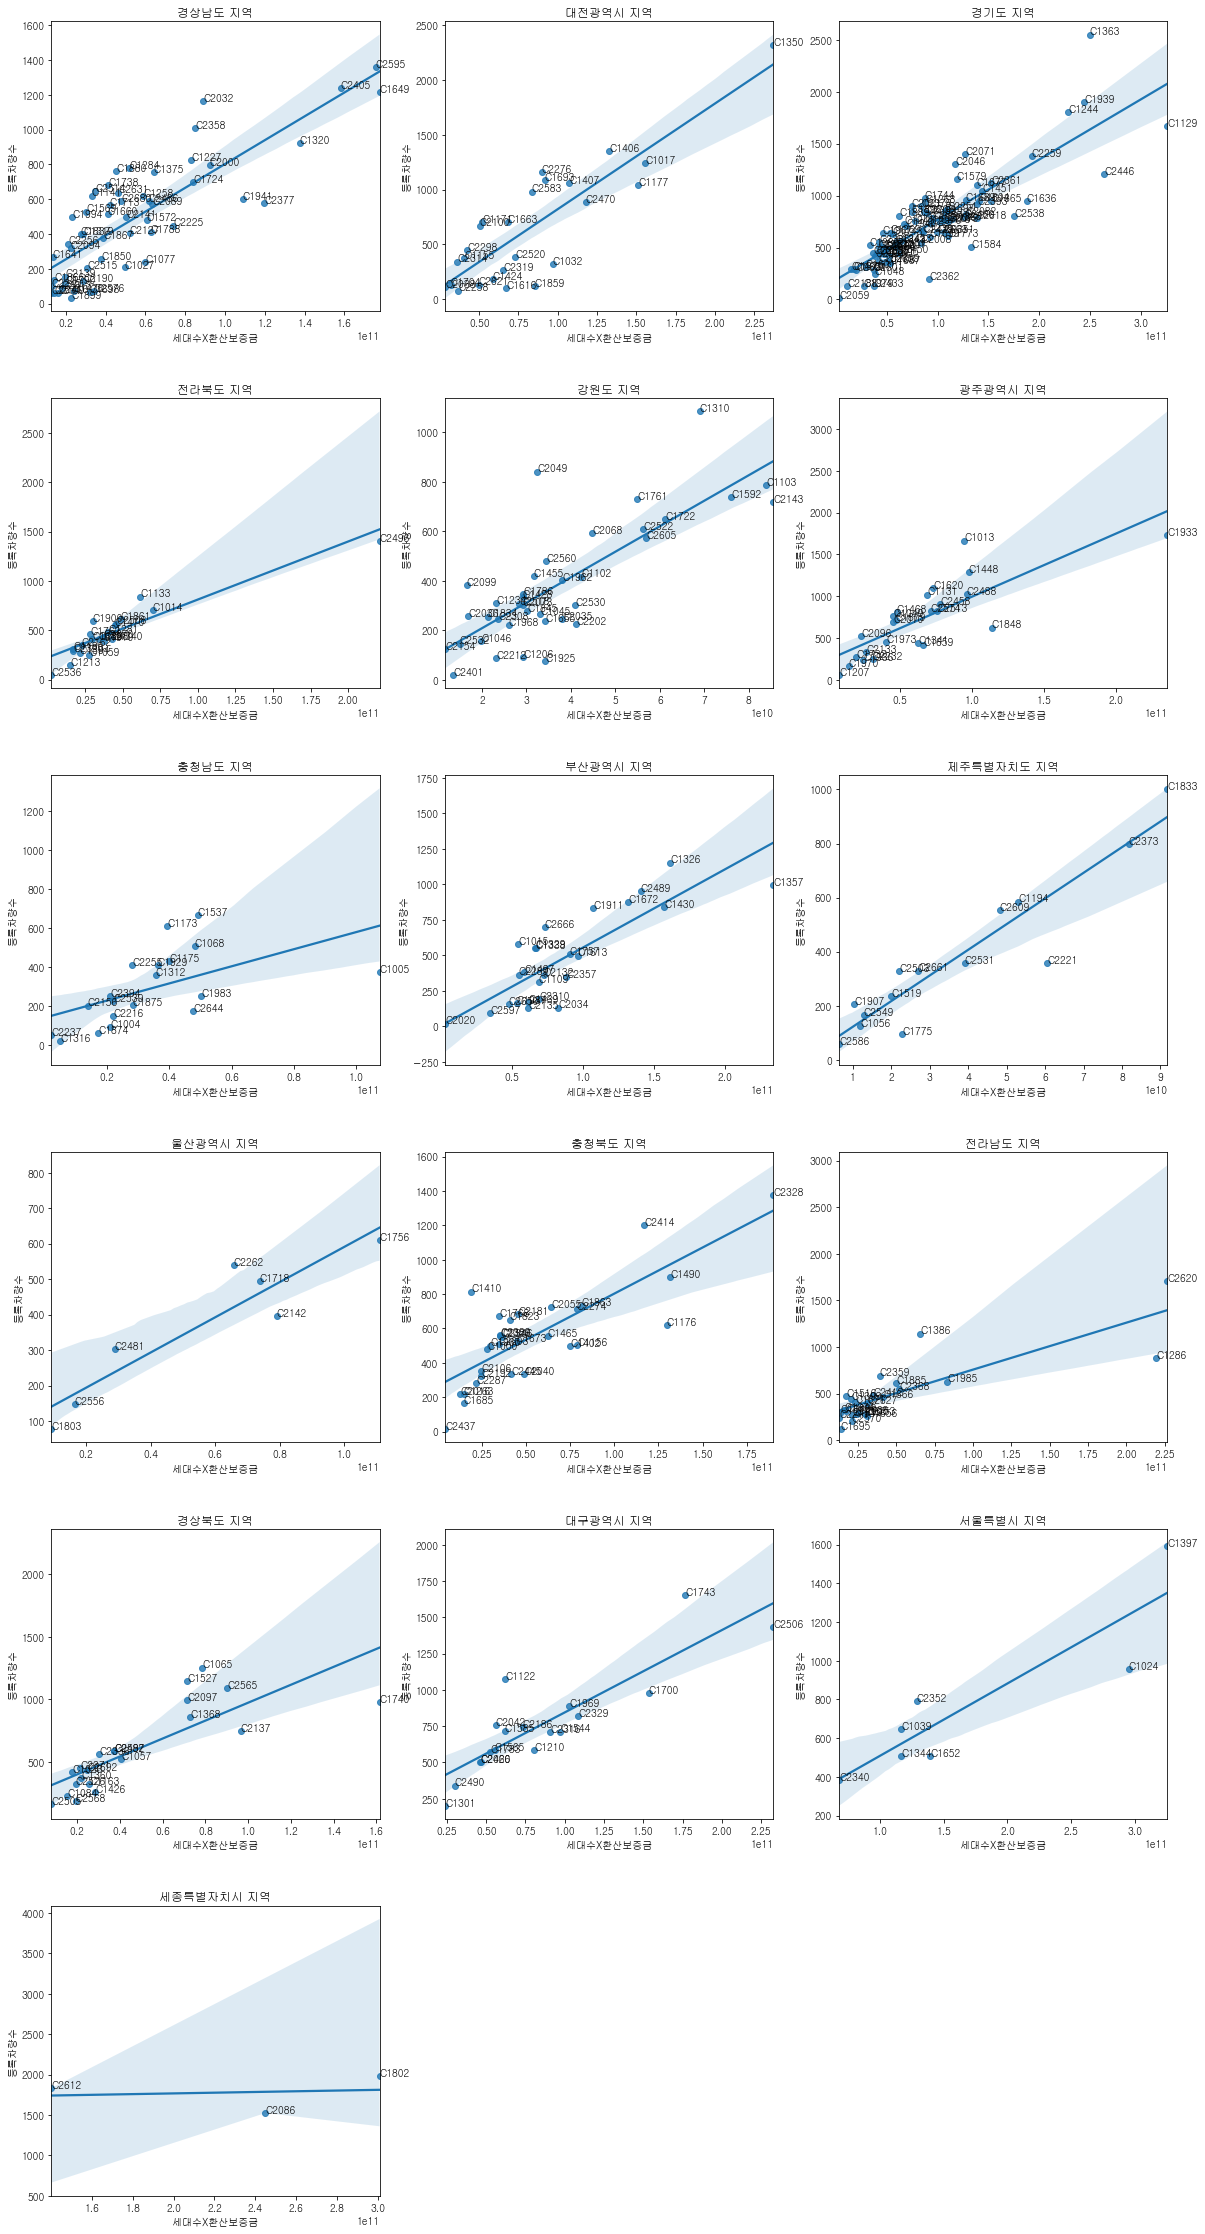

In [260]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(list(train_depot['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=train_depot.loc[train_depot['지역'] == n], x='세대수X환산보증금', y='등록차량수')
    for i, code in enumerate(train_depot.loc[train_depot['지역'] == n].reset_index(drop=True)['단지코드']):
        plots.annotate(code, (train_depot.loc[train_depot['지역'] == n].reset_index(drop=True)['세대수X환산보증금'][i],
                              train_depot.loc[train_depot['지역'] == n].reset_index(drop=True)['등록차량수'][i]))
    plt.title('{} 지역'.format(n))

- 확실히 총세대수, 주차면수, 건축연면적보다는 휘귀선이 조금 더 정확한 것을 알 수 있습니다.

### 대중교통은 차량보유에 영향을 미칠까?

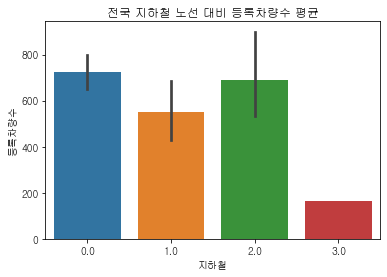

In [281]:
sns.barplot(data=train_danji.loc[train_danji['지역'].isin(['대전광역시', '경기도', '부산광역시', '대구광역시', '서울특별시'])],
            x='지하철', y='등록차량수')
plt.title('전국 지하철 노선 대비 등록차량수 평균')
plt.show()

별다른 정보를 주지 못하고 있다.

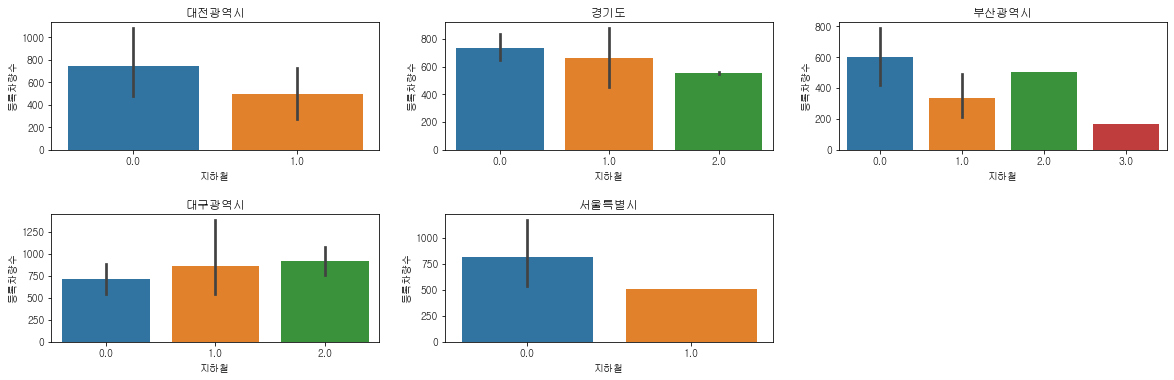

In [275]:
fig = plt.figure(figsize=(20, 20))
for i, n in enumerate(['대전광역시', '경기도', '부산광역시', '대구광역시', '서울특별시']):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.5)
    sns.barplot(data=train_danji.loc[train_danji['지역'] == n], x='지하철', y='등록차량수')
    plt.title(n)

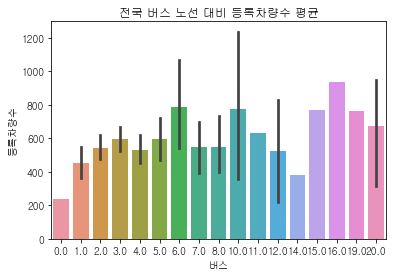

In [282]:
sns.barplot(data=train_danji, x='버스', y='등록차량수')
plt.title('전국 버스 노선 대비 등록차량수 평균')
plt.show()

오히려 버스 정류장이 많을수록 등록차량수가 늘어나는 패턴을 보인다.

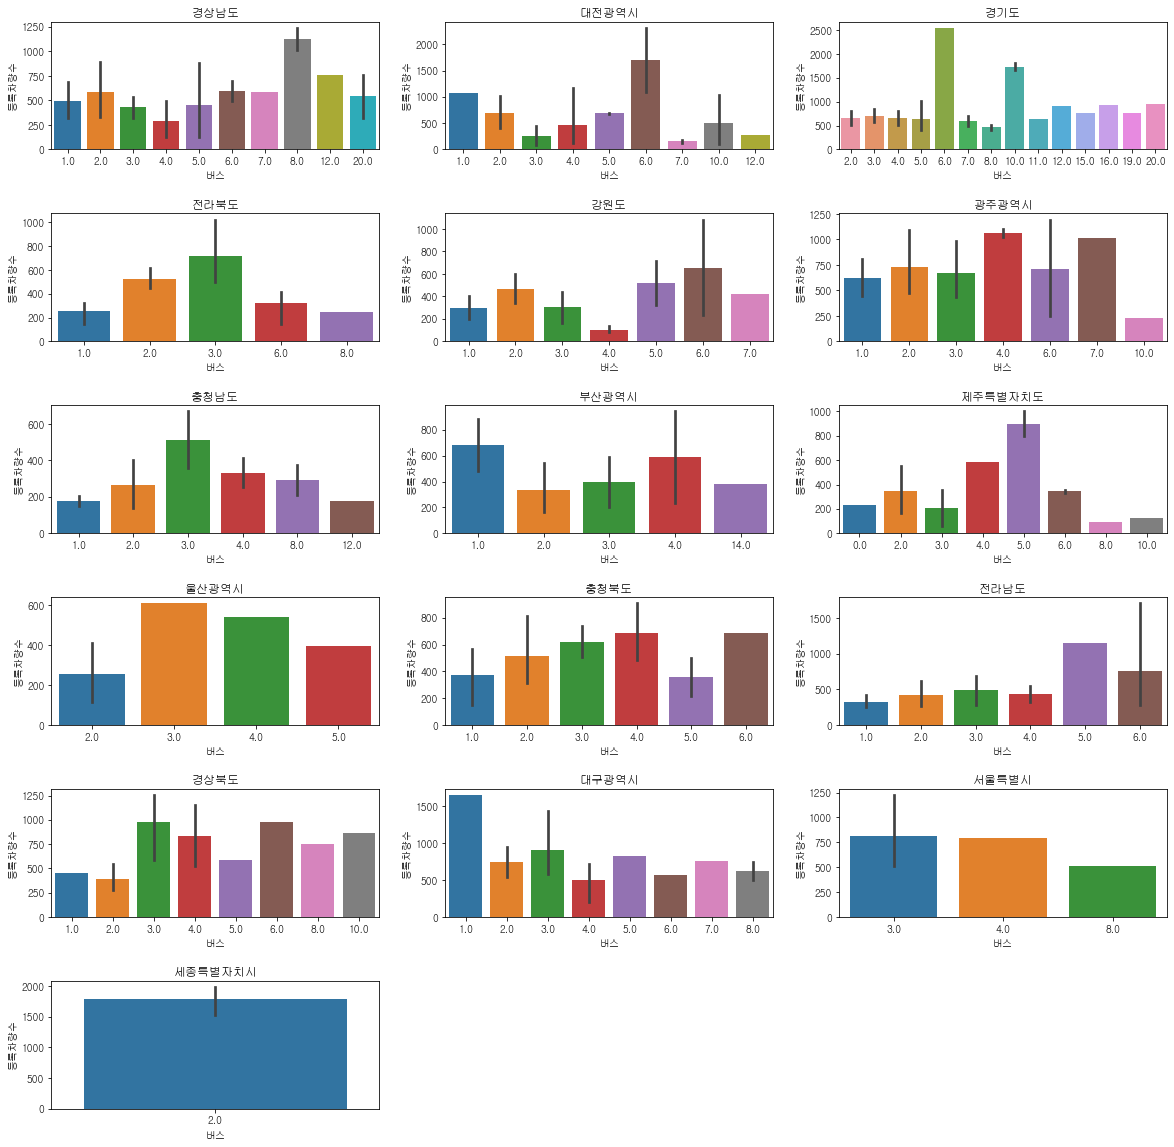

In [278]:
fig = plt.figure(figsize=(20, 20))
for i, n in enumerate(list(train_danji['지역'].unique())):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.5)
    sns.barplot(data=train_danji.loc[train_danji['지역'] == n], x='버스', y='등록차량수')
    plt.title(n)

지하철 하나가 버스 3개 수준이라면?

In [284]:
train_danji['대중교통'] = (train_danji['지하철'] * 3) + train_danji['버스']

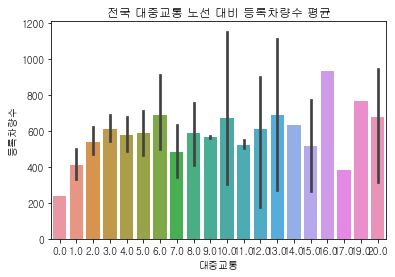

In [285]:
sns.barplot(data=train_danji, x='대중교통', y='등록차량수')
plt.title('전국 대중교통 노선 대비 등록차량수 평균')
plt.show()

# TESTING

### 1. 방의 개수가 차량 보유에 영향을 미치는가?

In [290]:
train.loc[train['전용면적'] < 35, '방개수'] = '1룸'
train.loc[train['전용면적'] >= 35, '방개수'] = '2룸'
train.loc[train['전용면적'] >= 45, '방개수'] = '3룸'
train.loc[train['전용면적'] >= 56, '방개수'] = '4룸'
train.loc[train['전용면적'] >= 77, '방개수'] = '5룸'

In [291]:
test.loc[test['전용면적'] < 35, '방개수'] = '1룸'
test.loc[test['전용면적'] >= 35, '방개수'] = '2룸'
test.loc[test['전용면적'] >= 45, '방개수'] = '3룸'
test.loc[test['전용면적'] >= 56, '방개수'] = '4룸'
test.loc[test['전용면적'] >= 77, '방개수'] = '5룸'

In [292]:
rooms = pd.pivot_table(train.loc[train['임대건물구분'] != '상가'],
                       index='단지코드', columns='방개수', values='전용면적별세대수',
                       aggfunc='sum')

In [293]:
temp = train.groupby(['단지코드'])[['총세대수', '지역', '단지내주차면수', '등록차량수']].max()

In [294]:
rooms_danji = pd.concat([rooms, temp], axis=1)

In [295]:
rooms_danji['1룸비율'] = rooms_danji['1룸'] / rooms_danji['총세대수']
rooms_danji['2룸비율'] = rooms_danji['2룸'] / rooms_danji['총세대수']
rooms_danji['3룸비율'] = rooms_danji['3룸'] / rooms_danji['총세대수']
rooms_danji['4룸비율'] = rooms_danji['4룸'] / rooms_danji['총세대수']
rooms_danji['5룸비율'] = rooms_danji['5룸'] / rooms_danji['총세대수']

rooms_danji['단지내주차면수/총세대수'] = rooms_danji['단지내주차면수'] / rooms_danji['총세대수']
rooms_danji['등록차량수/총세대수'] = rooms_danji['등록차량수'] / rooms_danji['총세대수']
rooms_danji['등록차량수/단지내주차면수'] = rooms_danji['등록차량수'] / rooms_danji['단지내주차면수']

In [296]:
rooms_cols = ['1룸비율', '2룸비율', '3룸비율', '4룸비율', '5룸비율']

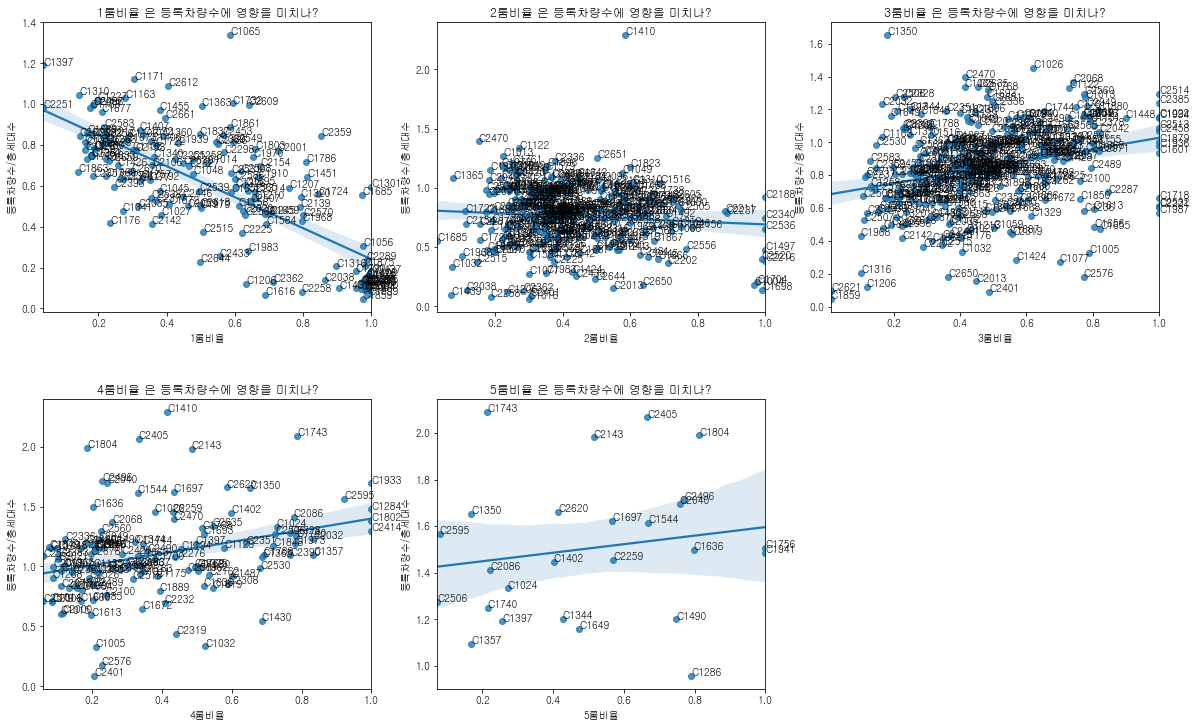

In [297]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(rooms_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=rooms_danji, x=n, y='등록차량수/총세대수')
    for i, code in enumerate(rooms_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (rooms_danji.reset_index(drop=False)[n][i],
                              rooms_danji.reset_index(drop=False)['등록차량수/총세대수'][i]))
    plt.title('{} 은 등록차량수에 영향을 미치나?'.format(n))

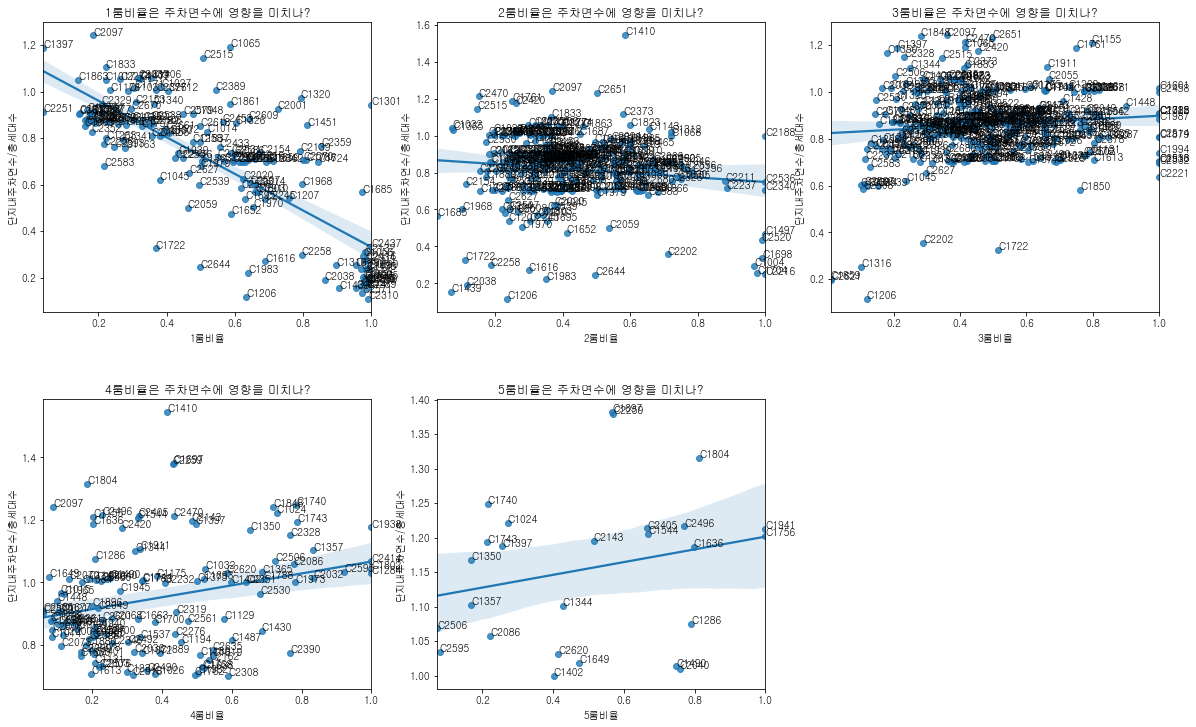

In [298]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(rooms_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=rooms_danji, x=n, y='단지내주차면수/총세대수')
    for i, code in enumerate(rooms_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (rooms_danji.reset_index(drop=False)[n][i],
                              rooms_danji.reset_index(drop=False)['단지내주차면수/총세대수'][i]))
    plt.title('{}은 주차면수에 영향을 미치나?'.format(n))

### 2. 크기 분류가 차량 보유에 영향을 미치는가?

In [300]:
# 80 ~ 은 대형
# 40 ~ 80 은 중형
# ~ 40 은 소형

train.loc[train['전용면적'] < 40, '전용면적구분'] = '소형'
train.loc[train['전용면적'] >= 40, '전용면적구분'] = '중형'
train.loc[train['전용면적'] >= 80, '전용면적구분'] = '대형'

test.loc[test['전용면적'] < 40, '전용면적구분'] = '소형'
test.loc[test['전용면적'] >= 40, '전용면적구분'] = '중형'
test.loc[test['전용면적'] >= 80, '전용면적구분'] = '대형'

In [301]:
size = pd.pivot_table(train.loc[train['임대건물구분'] != '상가'],
                       index='단지코드', columns='전용면적구분', values='전용면적별세대수',
                       aggfunc='sum')

In [302]:
temp = train.groupby(['단지코드'])[['총세대수', '지역', '단지내주차면수', '등록차량수']].max()

In [303]:
size_danji = pd.concat([size, temp], axis=1)

In [304]:
size_danji['소형비율'] = size_danji['소형'] / size_danji['총세대수']
size_danji['중형비율'] = size_danji['중형'] / size_danji['총세대수']
size_danji['대형비율'] = size_danji['대형'] / size_danji['총세대수']

size_danji['단지내주차면수/총세대수'] = size_danji['단지내주차면수'] / size_danji['총세대수']
size_danji['등록차량수/총세대수'] = size_danji['등록차량수'] / size_danji['총세대수']
size_danji['등록차량수/단지내주차면수'] = size_danji['등록차량수'] / size_danji['단지내주차면수']

In [305]:
size_cols = ['소형비율', '중형비율', '대형비율']

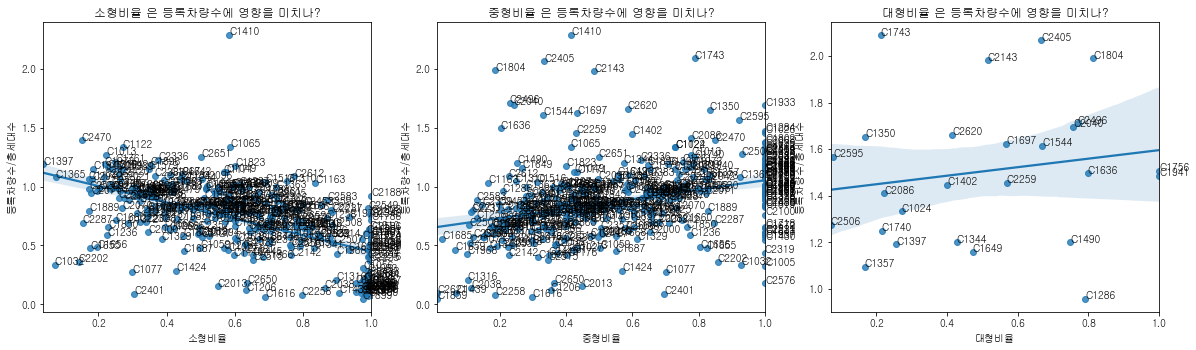

In [306]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(size_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=size_danji, x=n, y='등록차량수/총세대수')
    for i, code in enumerate(size_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (size_danji.reset_index(drop=False)[n][i],
                              size_danji.reset_index(drop=False)['등록차량수/총세대수'][i]))
    plt.title('{} 은 등록차량수에 영향을 미치나?'.format(n))

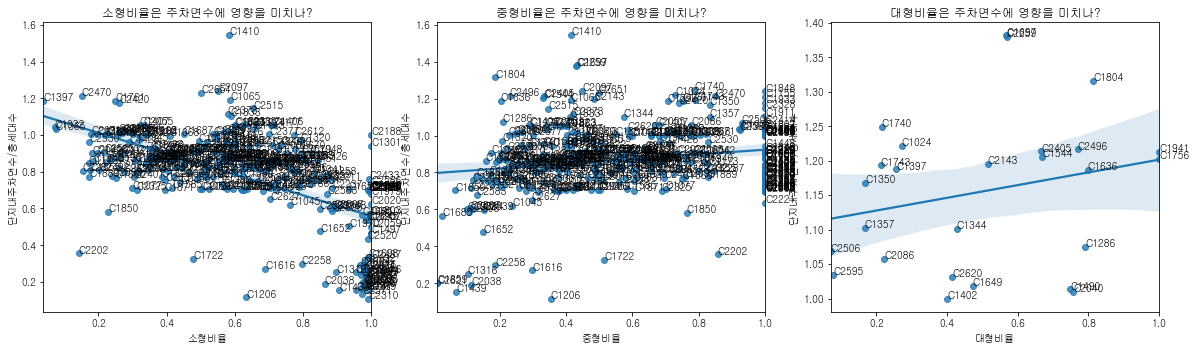

In [307]:
fig = plt.figure(figsize=(20, 40))
for i, n in enumerate(size_cols):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace=0.3)
    plots = sns.regplot(data=size_danji, x=n, y='단지내주차면수/총세대수')
    for i, code in enumerate(size_danji.reset_index(drop=False)['단지코드']):
        plots.annotate(code, (size_danji.reset_index(drop=False)[n][i],
                              size_danji.reset_index(drop=False)['단지내주차면수/총세대수'][i]))
    plt.title('{}은 주차면수에 영향을 미치나?'.format(n))

### 3. 땅값이 중요할까?

어떻게 하면 더 정확한 지가를 구할 수 있을까?

### 4. 지역별 세대, 성별 분포는 어떤 영향을 미칠까?

# Modeling

In [308]:
train.head()

단지코드  총세대수 임대건물구분    지역  공급유형   전용면적  전용면적별세대수   공가수 자격유형       임대보증금  \
8   C2515   545    아파트  경상남도  국민임대  33.48       276  17.0    A   9216000.0   
9   C2515   545    아파트  경상남도  국민임대  39.60        60  17.0    A  12672000.0   
10  C2515   545    아파트  경상남도  국민임대  39.60        20  17.0    A  12672000.0   
11  C2515   545    아파트  경상남도  국민임대  46.90        38  17.0    A  18433000.0   
12  C2515   545    아파트  경상남도  국민임대  46.90        19  17.0    A  18433000.0   

         임대료  지하철   버스  단지내주차면수  등록차량수         면적당보증금       면적당임대료  \
8    82940.0  0.0  3.0    624.0  205.0  275268.817204  2477.299881   
9   107130.0  0.0  3.0    624.0  205.0  320000.000000  2705.303030   
10  107130.0  0.0  3.0    624.0  205.0  320000.000000  2705.303030   
11  149760.0  0.0  3.0    624.0  205.0  393027.718550  3193.176972   
12  149760.0  0.0  3.0    624.0  205.0  393027.718550  3193.176972   

         환산보증금      면적당환산보증금    건축연면적     세대수X환산보증금 방개수 전용면적구분  
8   38576760.0  1.152233e+06  9240.48  1.064719e+10  1룸     소형  
9   50596020.0  1.277677e+06  2376.00  3.035761e+09  2룸     소형  
10  50596020.0  1.277677e+06   792.00  1.011920e+09  2룸     소형  
11  71448040.0  1.523412e+06  1782.20  2.715026e+09  3룸     중형  
12  71448040.0  1.523412e+06   891.10  1.357513e+09  3룸     중형

In [309]:
# 공급유형 unstack
temp = train.groupby(['단지코드', '공급유형'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['공급유형'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '공급유형'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['공급유형'])], temp, on='단지코드')

In [310]:
# 자격유형 unstack
temp = train.groupby(['단지코드', '자격유형'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['자격유형'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '자격유형'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['자격유형'])], temp, on='단지코드')

In [311]:
# 면적당환산보증금세대수 합계로 산출
temp = train.groupby(['단지코드'])['세대수X환산보증금'].sum().reset_index()
train = pd.merge(train.loc[:, ~train.columns.isin(['세대수X환산보증금'])], temp, on='단지코드')
temp = test.groupby(['단지코드'])['세대수X환산보증금'].sum().reset_index()
test = pd.merge(test.loc[:, ~test.columns.isin(['세대수X환산보증금'])], temp, on='단지코드')

In [312]:
# 방개수 unstack
temp = train.groupby(['단지코드', '방개수'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['방개수'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '방개수'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['방개수'])], temp, on='단지코드')

In [313]:
# 전용면적구분 unstack
temp = train.groupby(['단지코드', '전용면적구분'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['전용면적구분'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '전용면적구분'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['전용면적구분'])], temp, on='단지코드')

In [314]:
# 건축연면적 합계로 산출
temp = train.groupby(['단지코드'])['건축연면적'].sum().reset_index()
train = pd.merge(train.loc[:, ~train.columns.isin(['건축연면적'])], temp, on='단지코드')
temp = test.groupby(['단지코드'])['건축연면적'].sum().reset_index()
test = pd.merge(test.loc[:, ~test.columns.isin(['건축연면적'])], temp, on='단지코드')

In [315]:
# 실거주세대 대비 차량수의 지역 평균으로 오름차순 정렬
# Order를 주었습니다.
region_dict = {'서울특별시': 0,
               '경기도':1,
               '세종특별자치시':2,
               '경상북도':3,
               '대구광역시':4,
               '광주광역시':5,
               '충청북도':6,
               '전라남도':7,
               '전라북도':8,
               '강원도':9,
               '경상남도':10,
               '울산광역시':11,
               '제주특별자치도':12,
               '대전광역시':13,
               '충청남도':14,
               '부산광역시':15}

train['지역'] = train['지역'].map(region_dict)
test['지역'] = test['지역'].map(region_dict)

In [386]:
train

단지코드  총세대수  지역   공가수  지하철    버스  단지내주차면수   등록차량수  공공임대(10년)  공공임대(50년)  \
0    C2515   545  10  17.0  0.0   3.0    624.0   205.0        0.0        0.0   
1    C1407  1216  13  13.0  1.0   1.0   1285.0  1064.0        0.0        0.0   
2    C1945   755   1   6.0  1.0   3.0    734.0   730.0        0.0        0.0   
3    C1470   696   8  14.0  0.0   2.0    645.0   553.0        0.0        0.0   
4    C1898   566   8   9.0  0.0   6.0    517.0   415.0        0.0        0.0   
5    C1244  1722   1  10.0  0.0  10.0   1483.0  1804.0        0.0        0.0   
6    C1171   624  13  13.0  0.0   5.0    634.0   700.0        0.0        0.0   
7    C2073   361   9  13.0  0.0   5.0    288.0   301.0        0.0        0.0   
8    C2513   754   5  15.0  0.0   6.0    530.0   820.0        0.0        0.0   
9    C1936   240   5   8.0  0.0  10.0    168.0   234.0        0.0        0.0   
10   C2049   688   9   0.0  0.0   5.0    631.0   841.0        0.0        0.0   
11   C2202   623   9   0.0  0.0   2.0    222.0   226.0        0.0      623.0   
12   C1925   601   9   9.0  0.0   4.0    117.0    75.0        0.0        0.0   
13   C2576   405  10  19.0  0.0   4.0    296.0    73.0        0.0        0.0   
14   C1312   518  14  12.0  0.0   3.0    527.0   359.0        0.0        0.0   
15   C1874   619  14   2.0  0.0   2.0     97.0    62.0        0.0        0.0   
16   C2650   875  15  13.0  0.0   4.0    616.0   159.0        0.0        0.0   
17   C2416   560  10   0.0  0.0   5.0    154.0    63.0        0.0        0.0   
18   C2013   595  10   3.0  0.0   3.0    509.0    91.0        0.0        0.0   
19   C1424   625  13   2.0  0.0   7.0    517.0   179.0        0.0      624.0   
20   C2100   880  13   4.0  0.0   5.0    736.0   671.0        0.0        0.0   
21   C2621  1396  13  26.0  1.0   4.0    277.0   133.0        0.0        0.0   
22   C2520   970  13   2.0  0.0   2.0    420.0   386.0        0.0      960.0   
23   C2319   606  13   1.0  1.0  12.0    548.0   266.0        0.0        0.0   
24   C1616  1507  13   1.0  0.0   2.0    407.0    98.0        0.0        0.0   
25   C1704   639  13  34.0  0.0   7.0    162.0   131.0        0.0        0.0   
26   C2258   965  13  13.0  0.0   3.0    287.0    78.0        0.0        0.0   
27   C1032   946  13   6.0  1.0   2.0    986.0   316.0        0.0        0.0   
28   C2038   785  13   7.0  1.0  10.0    150.0   108.0        0.0        0.0   
29   C1859  2424  13   1.0  1.0   4.0    487.0   116.0        0.0        0.0   
30   C1722   809   9   1.0  0.0   6.0    264.0   649.0        0.0      505.0   
31   C1850   388  10   0.0  0.0   4.0    226.0   254.0        0.0      385.0   
32   C2190  1013  10   7.0  0.0   2.0    178.0   129.0        0.0        0.0   
33   C1476   453  10   6.0  0.0   5.0    107.0    70.0        0.0        0.0   
34   C1077   861  10  21.0  0.0   5.0    612.0   236.0        0.0        0.0   
35   C1068   806  14  11.0  0.0   2.0    804.0   510.0        0.0        0.0   
36   C1983   903  14   3.0  0.0   4.0    200.0   253.0        0.0      316.0   
37   C2135  1116  15  10.0  1.0   3.0    262.0   127.0        0.0        0.0   
38   C2034  1486  15   2.0  1.0   3.0    405.0   132.0        0.0        0.0   
39   C1109  1957  15   1.0  1.0   2.0    351.0   313.0        0.0        0.0   
40   C1497   802  15   7.0  1.0  14.0    375.0   382.0        0.0      802.0   
41   C2289  1527  15   2.0  0.0   3.0    240.0   364.0        0.0        0.0   
42   C2597  1005  15  25.0  0.0   2.0    166.0    94.0        0.0        0.0   
43   C2310  1988  15   1.0  0.0   2.0    217.0   189.0        0.0        0.0   
44   C1672  1350  15  15.0  0.0   1.0   1043.0   873.0        0.0        0.0   
45   C2132  2428  15   1.0  0.0   1.0    756.0   359.0        0.0        0.0   
46   C1439  1755  15  29.0  1.0   3.0    270.0   172.0        0.0        0.0   
47   C1613   840  15   7.0  1.0   1.0    594.0   498.0        0.0        0.0   
48   C2216   390  14   2.0  0.0   1.0     97.0   149.0        0.0      390.0   
49   C

In [387]:
test

단지코드  총세대수  지역   공가수  지하철    버스  단지내주차면수  공공임대(10년)  공공임대(50년)  \
0    C1072   754   1  14.0  0.0   2.0    683.0        0.0        0.0   
1    C1128  1354   1   9.0  0.0   3.0   1216.0        0.0        0.0   
2    C1456   619  15  18.0  0.0  16.0    547.0        0.0        0.0   
3    C1840   593   8   7.0  0.0   3.0    543.0        0.0        0.0   
4    C1332  1297   1  11.0  0.0   2.0   1112.0        0.0        0.0   
5    C1563  1974   1  15.0  0.0   6.0   1696.0        0.0        0.0   
6    C1794  1349   8  25.0  0.0   2.0   1098.0        0.0        0.0   
7    C1640   533   8  17.0  0.0   1.0    470.0        0.0        0.0   
8    C1377   470  10  18.0  0.0   4.0    384.0        0.0        0.0   
9    C2072   353  10   6.0  0.0   1.0    280.0        0.0        0.0   
10   C1472   548  14   2.0  0.0   1.0    442.0        0.0        0.0   
11   C1006  1505  13  27.0  2.0   5.0    428.0        0.0        0.0   
12   C1083   427  13   0.0  0.0   6.0    384.0        0.0        0.0   
13   C1311   383  15   2.0  0.0   2.0    265.0        0.0      383.0   
14   C2676  2572  15  25.0  0.0   2.0    418.0        0.0        0.0   
15   C2318   420  15   1.0  2.0   8.0    210.0        0.0      420.0   
16   C1603   602  12   0.0  0.0  10.0    491.0        0.0        0.0   
17   C2523   371   9   2.0  0.0  13.0    281.0        0.0        0.0   
18   C2177  1245  14   2.0  0.0   1.0    187.0        0.0        0.0   
19   C2411   962  10  25.0  0.0   2.0    840.0        0.0        0.0   
20   C2033  1400  11  12.0  0.0   7.0    308.0        0.0        0.0   
21   C1604   534  11  13.0  0.0   2.0    400.0        0.0        0.0   
22   C2535   558  11  23.0  0.0   2.0    480.0        0.0        0.0   
23   C1040   638  11  24.0  0.0   3.0    548.0        0.0        0.0   
24   C2417   494  11  21.0  0.0   4.0    447.0        0.0        0.0   
25   C1812  1021  11  22.0  0.0   4.0    185.0        0.0        0.0   
26   C2253  1161   9   0.0  0.0   2.0    173.0        0.0        0.0   
27   C1294   709   9  28.0  0.0   2.0    571.0        0.0        0.0   
28   C1772   496   9  25.0  0.0   3.0    593.0        0.0        0.0   
29   C2646   584   9  29.0  0.0   5.0    499.0        0.0        0.0   
30   C1152  1301  15  33.0  0.0   2.0   1101.0        0.0        0.0   
31   C2423   207  12   0.0  0.0   2.0    152.0        0.0        0.0   
32   C1844   620  12   0.0  0.0   4.0    498.0        0.0        0.0   
33   C1318   312  14   1.0  0.0  11.0    226.0        0.0      312.0   
34   C1729   627   9   0.0  0.0   5.0    131.0        0.0        0.0   
35   C1602   408   3   0.0  0.0   4.0    319.0        0.0        0.0   
36   C1239   498   6   3.0  0.0   8.0    425.0        0.0        0.0   
37   C1721   663   1  20.0  0.0   3.0    573.0        0.0        0.0   
38   C1902   980   1  21.0  0.0   5.0    841.0        0.0        0.0   
39   C1855   419   6  16.0  0.0   3.0    333.0        0.0        0.0   
40   C2600   540   8  10.0  0.0   6.0    458.0        0.0        0.0   
41   C1071   528   3  16.0  0.0   4.0    403.0        0.0        0.0   
42   C2295   496   3  22.0  0.0   1.0    378.0        0.0        0.0   
43   C1621   593   1   2.0  0.0   3.0    516.0        0.0        0.0   
44   C1852   898   1   6.0  0.0  50.0    785.0        0.0        0.0   
45   C2555  1442   5  23.0  0.0   6.0   1225.0        0.0        0.0   
46   C1297   449   5   8.0  0.0   3.0    448.0        0.0        0.0   
47   C2323   603   5  11.0  0.0   2.0    562.0        0.0        0.0   
48   C2215   496   5   8.0  0.0   6.0    350.0        0.0        0.0   
49   C2112   377   3  21.0  0.0   4.0    382.0        0.0        0.0   
50   C1830   891   1  17.0  1.0   7.0    805.0        0.0        0.0   
51   C2602   349   8   5.0  0.0   2.0    270.0        0.0        0.0   
52   C2608  1138   1  25.0  0.0   5.0   1141.0        0.0        0.0   
53   C1215   861  13   3.0  1.0   5.0    660.0        0.0        0.0   
54   C2369   656  14   3.0  0.0   3.0    528.0

In [317]:
# 전처리가 끝나서 필요없는 변수 삭제
train.drop(['임대건물구분', '전용면적', '전용면적별세대수', '임대보증금',
            '임대료', '환산보증금', '면적당보증금', '면적당임대료', '면적당환산보증금'], axis=1, inplace=True)
test.drop(['임대건물구분', '전용면적', '전용면적별세대수', '임대보증금',
           '임대료', '환산보증금', '면적당보증금', '면적당임대료', '면적당환산보증금'], axis=1, inplace=True)

In [322]:
# 단지고유의 레코드만 남겨줍니다.
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

In [323]:
train.shape, test.shape

((413, 43), (147, 36))

In [325]:
set(train.columns).difference(test.columns)

{'B', 'F', 'O', '공공분양', '공공임대(5년)', '등록차량수', '장기전세'}

In [326]:
train.drop(['B', 'F', 'O', '공공분양','공공임대(5년)', '장기전세'], axis=1, inplace=True)

In [327]:
# test['B'] = 0
# test['F'] = 0
# test['O'] = 0
# test['공공분양'] = 0
# test['공공임대(5년)'] = 0
# test['장기전세'] = 0

In [328]:
train.shape, test.shape

((413, 37), (147, 36))

In [340]:
x_train = train.loc[:, ~train.columns.isin(['단지코드', '등록차량수'])]
y_train = train['등록차량수']
x_test = test.loc[:, ~test.columns.isin(['단지코드'])]
x_code = test['단지코드']

In [342]:
x_train.shape, y_train.shape, x_test.shape, x_code.shape

((413, 35), (413,), (147, 35), (147,))

In [343]:
rf = RandomForestRegressor(random_state=42, oob_score=True, criterion='mse', n_estimators=200)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)

In [344]:
rf.oob_score_

0.7918777718578367

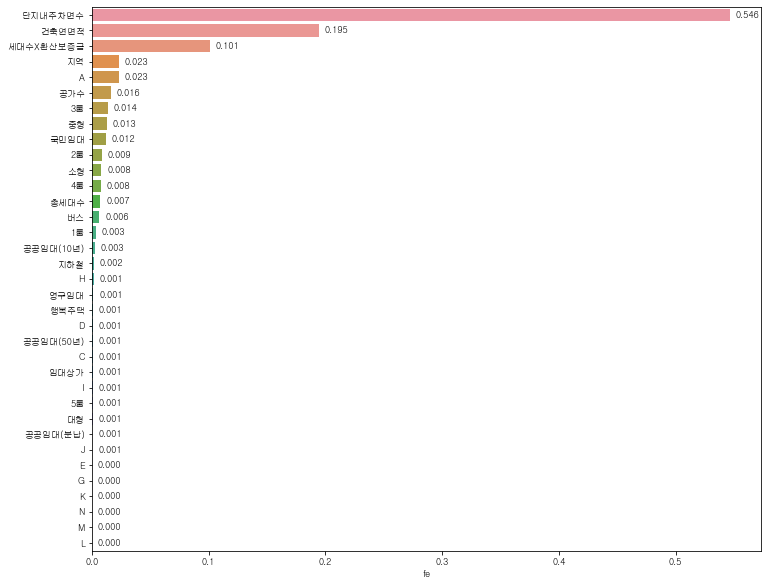

In [345]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "9"

fe_avg = pd.DataFrame(rf.feature_importances_,
                      index=x_train.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 10))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

In [355]:
sub = pd.merge(sub, pd.DataFrame(pred, index=x_code, columns=['pred']).reset_index(),
               how='left', left_on='code', right_on='단지코드').fillna(0)[['code', 'pred']]

In [358]:
sub.rename({'pred':'num'}, axis=1, inplace=True)

In [361]:
sub.head()

code       num
0  C1072   807.515
1  C1128  1114.550
2  C1456   520.855
3  C1840   515.615
4  C1332  1253.915

In [359]:
sub.to_csv('submission/parking_210711_allnew.csv', index=False)

### age_gender 추가

In [362]:
ag = age_gender.set_index('지역')

In [363]:
# 성인(20대~60대)비중합
ag.loc[:, '청년비중'] = ag.loc[:, (ag.columns.str.contains('20대')) | (ag.columns.str.contains('30대')) | (ag.columns.str.contains('40대')) | (ag.columns.str.contains('50대')) | (ag.columns.str.contains('60대'))].sum(axis=1)
# 미성년자(10대이하)비중
ag.loc[:, '미성년자비중'] = ag.loc[:, (ag.columns.str.contains('10대'))].sum(axis=1)
# 노인비중(70대~)비중합
ag.loc[:, '노년비중'] = ag.loc[:, (ag.columns.str.contains('70대')) | (ag.columns.str.contains('80대')) | (ag.columns.str.contains('90대')) | (ag.columns.str.contains('100대'))].sum(axis=1)
# 성인여성비중
ag.loc[:, '청년여성비중'] = ag.loc[:, ['20대(여자)', '30대(여자)', '40대(여자)', '50대(여자)', '60대(여자)']].sum(axis=1)
# 성인남성비중
ag.loc[:, '청년남성비중'] = ag.loc[:, ['20대(남자)', '30대(남자)', '40대(남자)', '50대(남자)', '60대(남자)']].sum(axis=1)

In [364]:
ag = ag.reset_index()
ag['지역'] = ag['지역'].map(region_dict)

In [365]:
train = pd.merge(train, ag, how='left', on='지역')
test = pd.merge(test, ag, how='left', on='지역')

In [366]:
train.shape, test.shape

((413, 64), (147, 63))

In [367]:
x_train = train.loc[:, ~train.columns.isin(['단지코드', '등록차량수'])]
y_train = train['등록차량수']
x_test = test.loc[:, ~test.columns.isin(['단지코드'])]
x_code = test['단지코드']

In [368]:
x_train.shape, y_train.shape, x_test.shape, x_code.shape

((413, 62), (413,), (147, 62), (147,))

In [381]:
rf = RandomForestRegressor(random_state=42, oob_score=True, criterion='mse', n_estimators=1000, n_jobs=-1)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)

In [382]:
rf.oob_score_

0.7913621046320137

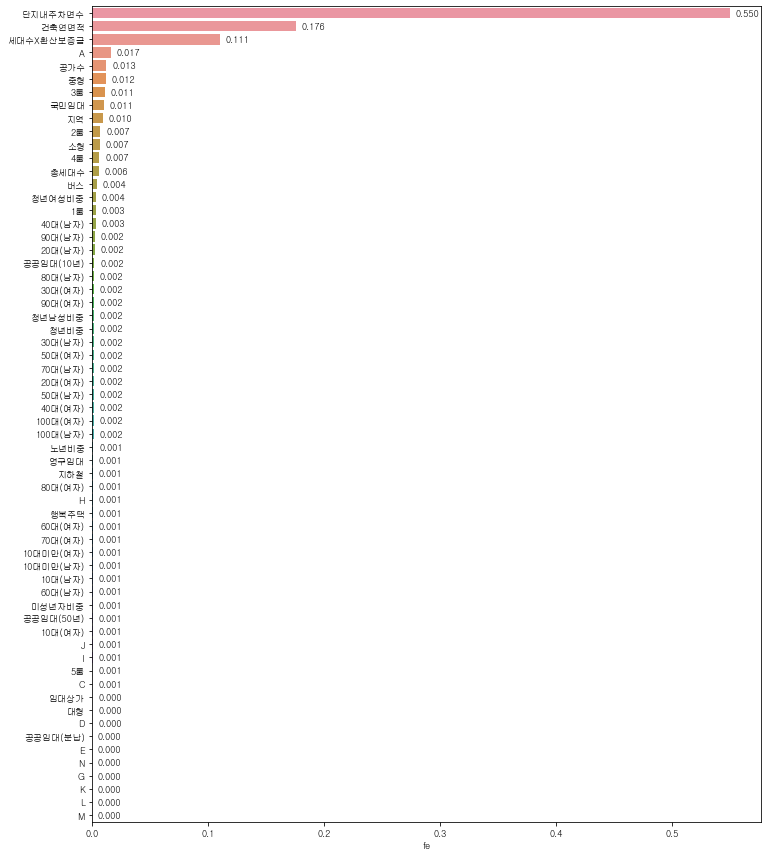

In [384]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "9"

fe_avg = pd.DataFrame(rf.feature_importances_,
                      index=x_train.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 15))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

In [372]:
sub = pd.merge(sub, pd.DataFrame(pred, index=x_code, columns=['pred']).reset_index(),
               how='left', left_on='code', right_on='단지코드').fillna(0)[['code', 'pred']]

In [373]:
sub.rename({'pred':'num'}, axis=1, inplace=True)

In [374]:
sub.head()

code       num
0  C1072   807.125
1  C1128  1151.535
2  C1456   482.250
3  C1840   499.420
4  C1332  1244.505

In [375]:
sub.to_csv('submission/parking_210711_allnew+ag.csv', index=False)